In [1]:
import pickle
import radvel
import rebound as rb
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from scipy import optimize, stats
import corner
from radvel.plot import mcmc_plots
import reboundx
import emcee
from multiprocessing import Pool
import h5py
import time
from celmech.nbody_simulation_utilities import align_simulation
from tqdm import tqdm
from emcee.interruptible_pool import InterruptiblePool
import os
from getdist import plots, MCSamples

/home/ianchow/.local/lib/python3.10/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


In [2]:
pl.rc('font', size=18)

In [3]:
MAY_1_2015 = 57143.5  # barycentric julian date for May 1, 2015 (the date of the HARPS instrument upgrade as per trifonov et al 2020)
# 57143.5 is BJD for May 1, 2015
# 57173.5 is BJD for May 31, 2015

# harps
hd_data_harps = pd.read_csv('hd45364_rvs.csv', sep = ';')
# giant outlier at position 116 in the data (found manually earlier) which we remove
hd_data_harps.drop(116, inplace=True)  # drop the row and keep the df in place
# subtract 2.4e6 from all the rows in the data
hd_data_harps.BJD -= 2.4e6
# rename target to HARPS1 or HARPS2
hd_data_harps['target'] = hd_data_harps.apply(lambda row: 'HARPS1' if row.BJD < MAY_1_2015 else 'HARPS2', axis = 1)
# hires
hd_data_hires = pd.read_csv('../hires_rvs.txt', sep = '\t', index_col=False, header='infer', dtype=np.float64)
hd_data_hires['BJD - 2,450,000'] += 50000.  # adding 50000 to have the same units as harps
hd_data_hires['target'] = 'HIRES'
hd_data_hires.columns = ['BJD', 'RV_mlc_nzp', 'e_RV_mlc_nzp', 'target']
# concatenate two data sets one on top of the other
hd_data = pd.concat((hd_data_harps, hd_data_hires), axis=0)  # matching BJD, RV_mlc_nzp and e_RV_mlc_nzp columns
# reset index
hd_data.reset_index(drop=True, inplace=True)

In [4]:
#Very original parameters used in Hadden and Payne
nbody_params =[ 2.27798546e+02,  7.25405874e+00,  5.39392010e+04,  1.71866112e-01, 1.17923823e-01,  
               3.43881599e+02,  1.87692753e+01,  5.40138425e+04, 1.68408461e-01,  5.05903191e-02, 
               -3.28526403e-03, 0., 0., 
               1, 
               1.84, 0., 0.]  # inserted 0 for harps2 and hires for both rv offset and jitter

# #Least squares fit: 
# fit_params = [ 2.28512793e+02, 7.27736501e+00, 5.39371914e+04, -4.66868256e-02, 
#                -1.78080009e-01, 3.43378038e+02, 1.78603341e+01, 5.40186750e+04, 
#                9.72945632e-02,  1.32194117e-01, -5.29072002e-01, 0., 0., 1, 2.428]#-7.68527759e-03] 

# Neg log likelihood jitter fit:

fit_params = [2.27859008e+02, 7.20396587e+00,  5.39386707e+04, -7.17270858e-03, -2.13670237e-01,
              3.44028221e+02, 1.82216479e+01,  5.47055869e+04, 1.14530821e-01,  3.81765820e-02,
              -1.38087163e-01, -2.89290650e+00, 1.70788055e+00, 
              1.00000000e+00,
              2.15025156e+00, 1.48605174e+00, 4.42809302e+00] 


In [5]:
## CONSTANTS:

STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

obs_time_base = np.median(hd_data_harps.BJD)

# print(f'nbody_params:{nbody_params}\n fit_params:{fit_params}')

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude (in au/day)
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))


def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude (in au/day) to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset for HARPS1
    params[5 * num_planets + 1] is rv offset for HARPS2
    params[5 * num_planets + 2] is rv offset for HIRES
    params[5 * num_planets + 3] is sin(i)
    params[5 * num_planets + 4] is jitter for HARPS1
    params[5 * num_planets + 5] is jitter for HARPS2
    params[5 * num_planets + 6] is jitter for HIRES
    
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = 2 # 2 planets
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * np.min([params[0], params[5]])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')
    sim.add(m = star_mass)  # star mass as a constant
    
    inclination = np.arcsin(params[-4])  # sin(i) is fourth from the back of the array
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 4], params[5*i + 3])  # omega from arctan of sesin, secos  (in that order!)
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(tc = params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim


def get_rvs(params, instrument, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset for HARPS1
    params[5 * num_planets + 1] is rv offset for HARPS2
    params[5 * num_planets + 2] is rv offset for HIRES
    params[5 * num_planets + 3] is sin(i) (also params[-4])
    params[5 * num_planets + 4] is jitter for HARPS1 (also params[-3])
    params[5 * num_planets + 5] is jitter for HARPS2 (also params[-2])
    params[5 * num_planets + 6] is jitter for HIRES (also params[-1])

    param instrument: instrument (HARPS1, HARPS2, or HIRES)
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    
    sim = get_sim_from_params(params, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards

    times = pd.Series(times)  # convert to series if not already
    
    forward_times = times[times - obs_time_base >= 0]
    backward_times = times[times - obs_time_base < 0]
    forward_indices = forward_times.index
    backward_indices = backward_times.index
    
    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))
    
    num_planets = 2  # find number of planets in params passed
    
    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for j, it in enumerate(zip(forward_indices, forward_times)):
        i, t = it  # forward index, forward time
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time, exact_finish_time = 1 for ias15, 
        # sim.status()
        star = sim.particles[0]
        # print(instrument[i])
        # use one of 3 different radial velocity offsets depending on whether the data is from HARPS1, HARPS2 or HIRES
        if instrument[i] == 'HARPS1':
            rv_offset = params[5 * num_planets]
        elif instrument[i] == 'HARPS2':
            rv_offset = params[5 * num_planets + 1]
        elif instrument[i] == 'HIRES':
            rv_offset = params[5 * num_planets + 2]
        else:
            rv_offset = 0.
        rv_forward[j] = (-star.vz * auday_ms) + rv_offset  # use x-velocity of the star as the radial velocity, convert to m/s
    
    for j, it in enumerate(zip(backward_indices, backward_times)):
        i, t = it  # backward index, backward time
        sim_backwards.integrate(t, exact_finish_time = 1)
        star = sim_backwards.particles[0]
        # use one of 3 different radial velocity offsets depending on whether the data is from HARPS1, HARPS2 or HIRES
        # print(instrument[i])
        if instrument[i] == 'HARPS1':
            rv_offset = params[5 * num_planets]
        elif instrument[i] == 'HARPS2':
            rv_offset = params[5 * num_planets + 1]
        elif instrument[i] == 'HIRES':
            rv_offset = params[5 * num_planets + 2]
        else:
            rv_offset = 0.
        rv_backward[j] = (-star.vz * auday_ms) + rv_offset
    
    return np.concatenate((rv_backward, rv_forward))

Compute best fit:

In [6]:
def get_nbody_resids(params, integrator, data = hd_data):
    """
    Gets the normalized residuals for the n-body fit with REBOUND
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    synth_y = get_rvs(params, data.target, data.BJD, integrator, time_base=obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors
    return (obs_y - synth_y) / obs_yerr  # return normalized residuals


def neg_log_likelihood(params, data = hd_data):
    """
    Gets the negative log-likelihood (including a jitter term!) for use with scipy.optimize.minimze
    
    Iplements the log likelihood using the same method above
    
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    
    # inclination not handled sparately
    # inclination = np.arcsin(params[-4])  # inclination is np.arcsin of the second to last parameter
    
    synth_y = get_rvs(params, data.target, data.BJD, 'ias15', time_base = obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors

    conditions = [data.target == 'HARPS1', data.target == 'HARPS2', data.target == 'HIRES']  # conditions are harps1, harps2 or hires
    jitters = params[-3:]  # jitters for HARPS1, HARPS2 and HIRES, in that order
    
    # get the jitter values for the corresponding data points
    jitter = np.select(conditions, jitters, default=np.nan)

    # compute the log-likelihood
    log_likelihood = -1/2 * np.sum(((obs_y - synth_y) ** 2)/(obs_yerr ** 2 + jitter ** 2) 
                                   + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2))))
    
    # log_likelihood = -1/2 * np.sum(np.log(variance) + ((obs_y - synth_y) ** 2/variance))
    
    return -log_likelihood  # negative since we are trying to minimize the negative log likelihood

In [7]:
# bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0], 
#           [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 1])

# fit_params = optimize.least_squares(lambda params: get_nbody_resids(params, integrator = 'ias15'), nbody_params, bounds=bounds)

# bounds of (0, 1) for sin(i), everything else can vary however
bounds = ((None, None), (None, None), (None, None), (None, None), (None, None), 
          (None, None), (None, None), (None, None), (None, None), (None, None), 
          (None, None), (None, None), (None, None),
          (0, 1), 
          (None, None), (None, None), (None, None))

best_fit_jitter = optimize.minimize(neg_log_likelihood, x0=np.array(fit_params), method='Nelder-Mead', 
                                    bounds=bounds, options={'maxiter': np.inf, 'maxfev': np.inf})  # optimization

## February 2024:

- Get posteriors for A-penalty = [0.1,…,1] - Posteriors —> tau_a / tau_e
 - Mass upper limit as function of tau_a/tau_e (e.g., geomspace(3,1000)
    - Start sims with small masses (e.g., m~1e-6), taking m1/m2 based on posterior median
    - Migrate and capture in resonance for fixed tau_a/tau_e
    - turn off tau_a and tau_e
    - Use reboundx grow masses and determine maximum stable massesasses


### Mass upper limit:

Start by getting the mass upper limit (also can find the lower bound for $\sin(i)$ that we should be using for the mcmc chains?) by importing the unpenalized chains (although the masses don't differ but that much between the unpenalized and penalized versions anyway):

In [8]:
cluster_data = h5py.File('../mcmc_hd45364_cluster_everything.h5', 'r')  # import data
accepted, samples, log_prob = np.array(cluster_data['mcmc']['accepted']), np.array(cluster_data['mcmc']['chain']), np.array(cluster_data['mcmc']['log_prob'])

Remove the "burn-in" phase:

In [9]:
burnin = 200  # number of sampels to discard for burn-in

accepted = accepted[burnin:]
samples = samples[burnin:]
log_prob = log_prob[burnin:]

Plotting the chains for the inner planet, outer planet, and rv_offsetjitter/sini:

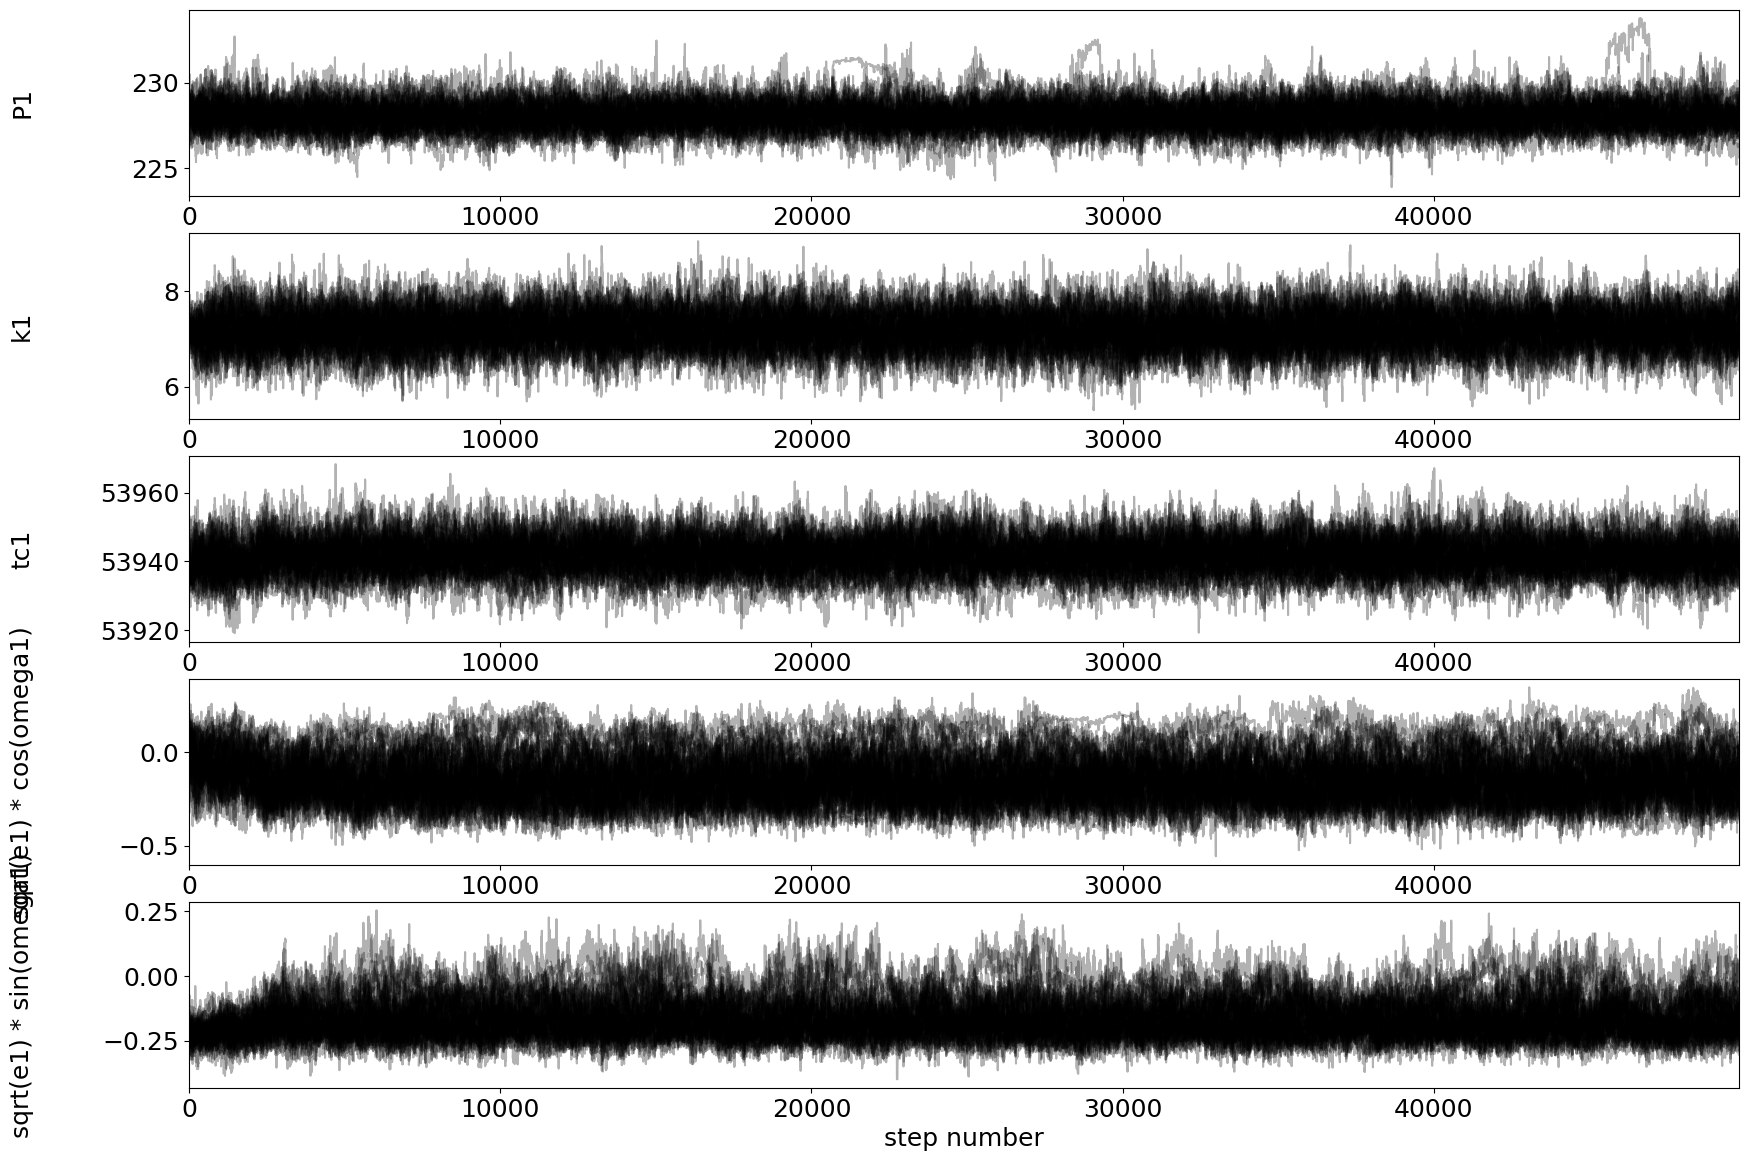

In [10]:
_, axes = pl.subplots(5, figsize=(20, 14))
labels1 = ['P1', 'k1', 'tc1', 'sqrt(e1) * cos(omega1)', 'sqrt(e1) * sin(omega1)']

for i in range(5):
    ax = axes[i]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels1[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

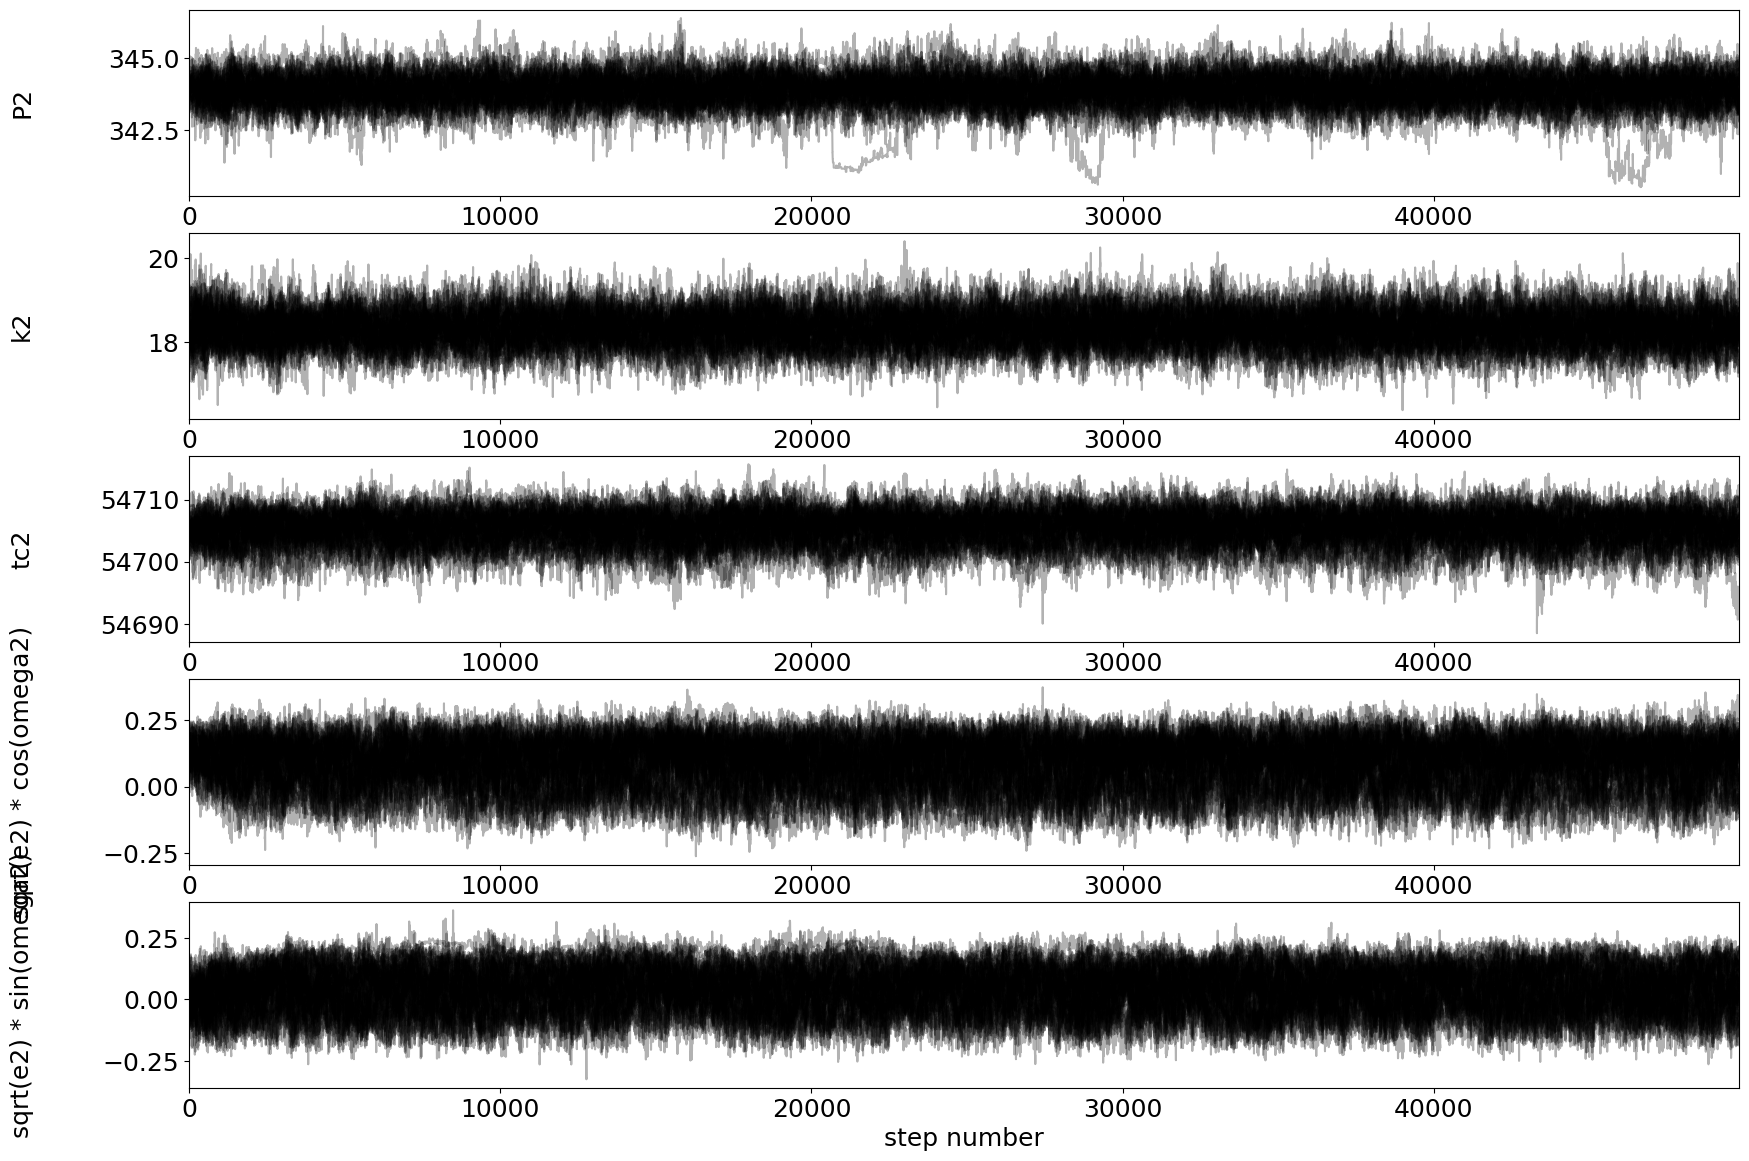

In [11]:
_, axes = pl.subplots(5, figsize=(20, 14))
labels2 = ['P2', 'k2', 'tc2', 'sqrt(e2) * cos(omega2)', 'sqrt(e2) * sin(omega2)']

for i in range(5, 10):
    ax = axes[i - 5]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels2[i - 5])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

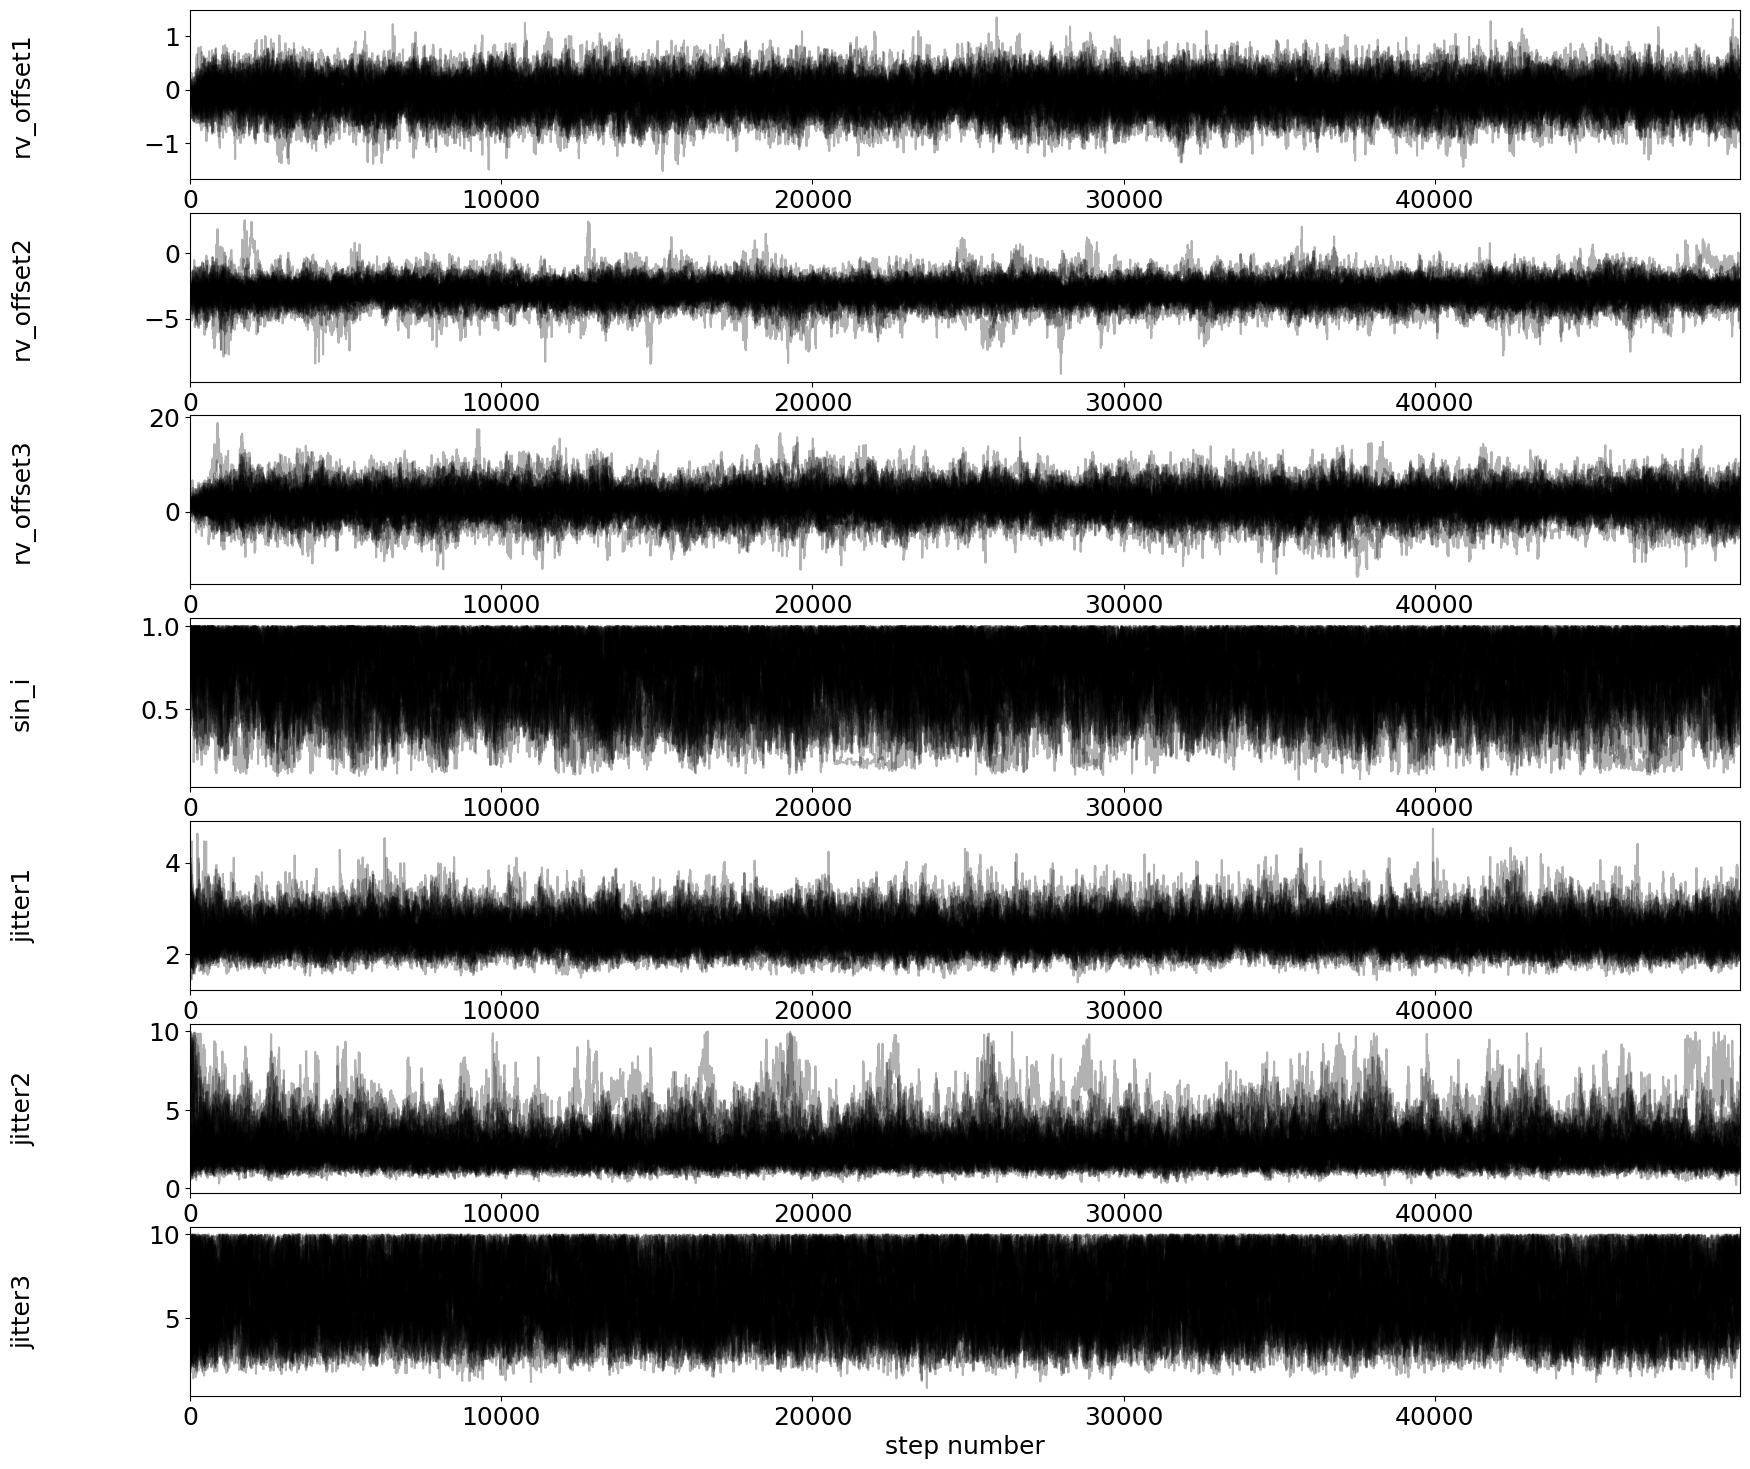

In [12]:
_, axes = pl.subplots(7, figsize=(20, 18))
labels3 = ['rv_offset1', 'rv_offset2', 'rv_offset3', 'sin_i', 'jitter1', 'jitter2', 'jitter3']
for i in range(10, 17):
    ax=axes[i - 10]
    ax.plot(samples[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels3[i - 10])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");
        
# pl.figure(figsize = (20, 4))
# pl.plot(samples[:, :, 10], 'k', alpha = 0.3)
# pl.xlim(0, len(samples))
# pl.xlabel('step number'), pl.ylabel('rv_offset')

Computing posterior distribution of orbital elements:

In [13]:
best = best_fit_jitter.x

e1 = samples[:, :, 3] ** 2 + samples[:, :, 4] ** 2  # computing eccentricity
e2 = samples[:, :, 8] ** 2 + samples[:, :, 9] ** 2  # computing eccentricity
p1 = samples[:, :, 0]
k1 = samples[:, :, 1]
p2 = samples[:, :, 5]
k2 = samples[:, :, 6]
tc1 = samples[:, :, 2]
tc2 = samples[:, :, 7]
omega1 = np.arctan2(samples[:, :, 3], samples[:, :, 4])  # omega is argument of periapsis
omega2 = np.arctan2(samples[:, :, 8], samples[:, :, 9])

rv_offset1 = samples[:, :, 10]  # rv_offset
rv_offset2 = samples[:, :, 11]  # rv_offset
rv_offset3 = samples[:, :, 12]  # rv_offset
sin_i = samples[:, :, 13] # sin_i
jitter1 = samples[:, :, 14]
jitter2 = samples[:, :, 15]
jitter3 = samples[:, :, 16]

 # print(k1.shape, p1.shape, e1.shape)

m1 = semiamp_to_mass(k1/(AUDAY_MS), STAR_MASS, p1, e1, inclination = np.arcsin(sin_i))
m2 = semiamp_to_mass(k2/(AUDAY_MS), STAR_MASS, p2, e2, inclination = np.arcsin(sin_i))
# print(m1.shape, e1.shape, m2.shape, e1.shape)

In [14]:
p1_best, k1_best, tc1_best, sq_e1cosomega1_best, sq_e1sinomega1_best, p2_best, k2_best, tc2_best, sq_e2cosomega2_best, sq_e2sinomega2_best, rv_offset1_best, rv_offset2_best, rv_offset3_best, sini_best, jitter1_best, jitter2_best, jitter3_best = best
e1_best = sq_e1cosomega1_best ** 2 + sq_e1sinomega1_best ** 2
e2_best = sq_e2cosomega2_best ** 2 + sq_e2sinomega2_best ** 2
omega1_best = np.arctan2(sq_e1cosomega1_best, sq_e1sinomega1_best)
omega2_best = np.arctan2(sq_e2cosomega2_best, sq_e2sinomega2_best)

m1_best = semiamp_to_mass(k1_best/AUDAY_MS, STAR_MASS, p1_best, e1_best, inclination = np.arcsin(sini_best))
m2_best = semiamp_to_mass(k2_best/AUDAY_MS, STAR_MASS, p2_best, e2_best, inclination = np.arcsin(sini_best))

pd.DataFrame(data = [m1_best, p1_best, e1_best, tc1_best, omega1_best, 
                     m2_best, p2_best, e2_best, tc2_best, omega2_best, 
                     rv_offset1_best, rv_offset2_best, rv_offset3_best, 
                     sini_best, 
                     jitter1_best, jitter2_best, jitter3_best], 
             index = ['m1', 'p1', 'e1', 'tc1', 'omega1', 
                      'm2', 'p2', 'e2', 'tc2', 'omega2', 
                      'rv_offset1', 'rv_offset2', 'rv_offset3', 
                      'sin_i', 
                      'jitter1', 'jitter2', 'jitter3'], 
             columns=['best'])

best
m1              0.198382
p1            227.859014
e1              0.045706
tc1         53938.670694
omega1         -3.108023
m2              0.576194
p2            344.028217
e2              0.014575
tc2         54705.586908
omega2          1.249043
rv_offset1     -0.138093
rv_offset2     -2.892910
rv_offset3      1.707934
sin_i           1.000000
jitter1         2.150248
jitter2         1.486042
jitter3         4.428118

In [15]:
pd.DataFrame(data=[np.quantile(m1.reshape(-1), [0.05, 0.5, 0.95]), 
                   np.quantile(p1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(e1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(tc1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(omega1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(m2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(p2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(e2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(tc2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(omega2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(rv_offset1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(rv_offset2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(rv_offset3.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(sin_i.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(jitter1.reshape(-1), [0.01, 0.5, 0.95]),
                   np.quantile(jitter2.reshape(-1), [0.01, 0.5, 0.95]), 
                   np.quantile(jitter3.reshape(-1), [0.01, 0.5, 0.95])
                  ], index = ['m1', 'p1', 'e1', 'tc1', 'omega1', 
                              'm2', 'p2', 'e2', 'tc2', 'omega2', 
                              'rv_offset1', 'rv_offset2', 'rv_offset3',
                              'sin_i',
                              'jitter1', 'jitter2', 'jitter3'], 
             columns=['5%', '50%', '95%'])

5%           50%           95%
m1              0.198727      0.255507      0.470394
p1            226.889280    228.012774    229.228122
e1              0.018117      0.063760      0.119900
tc1         53933.728618  53941.192368  53949.026156
omega1         -2.998677     -2.272369      2.938194
m2              0.588292      0.746158      1.382381
p2            343.146937    343.914843    344.667875
e2              0.002122      0.022036      0.054824
tc2         54701.064567  54705.580063  54709.168104
omega2         -2.004236      1.004438      2.506534
rv_offset1     -0.549560     -0.098491      0.334722
rv_offset2     -4.090633     -2.952036     -1.833545
rv_offset3     -2.427987      1.854364      6.239378
sin_i           0.421461      0.774787      0.978848
jitter1         1.845606      2.426949      2.990815
jitter2         1.007228      2.307600      4.292627
jitter3         2.687480      6.386458      9.544640

In [16]:
np.quantile(log_prob.reshape(-1), [0.05, 0.5, 0.95]), np.max(log_prob.reshape(-1))

(array([-161.31178493, -154.96471005, -150.67531488]), -146.95651055927252)

In [17]:
# best fit using neg log likelihood, random sample
neg_log_likelihood(best), neg_log_likelihood(samples[25000][25])

(145.83699351660437, 157.14756793644318)

### Maximum mass simulations:

Start sims with $m_1$ as the minimum $m_1$ in the chains (note that `get_simple_sim()` takes masses in units of star masses), and take $m_2/m_1$ to be based on the posterior median (median of m2/m1, not (median of m2)/(median of m1)), before growing the masses:

In [18]:
m2m1_median = np.median(m2.reshape(-1)/m1.reshape(-1))  # m2/m1 based on the posterior median
m1_init = 1.e-6# np.min(m1)/STAR_MASS  # initial mass of m1, in star masses

Create array of $K = \tau_a/\tau_e$ values to iterate over:

In [19]:
nsims = 1000
Ks = np.geomspace(9, 500, nsims)

Initialize simulation with specific $K$ value, migrate and capture in resonance for each $K$ value, turn off $\tau_a$ and $\tau_e$, and then grow masses until they become unstable:

In [20]:
def get_tau_alphas(tau_alpha, m_inner, m_outer, period_ratio):
    """
    helper function to get tau_a values for the maximum stable mass computation

    returns (tau_a_outer, tau_a_inner) as a tuple
    """
    # use Kepler's third law to compute the ratio of semi-major axes in resonance from the period ratio in resonance
    sma_ratio = period_ratio ** (2/3)  # ratio of outer planet's semi-major axis to inner
    # define matrix A
    A = np.array([[-1, 1],
                 [m_outer, m_inner * sma_ratio]])
    # compute gamma_1 and gamma_2
    gammas = np.matmul(np.linalg.inv(A), np.array([-1/tau_alpha, 0]))
    # gamma = 1/tau
    taus = 1/gammas
    
    return tuple(taus)  # returns (tau_alpha_outer, tau_alpha_inner) as a tuple

# NOTE: could change tau_e_factor to be a little larger, think that might cause the eccentricities to approach
# the upper asymptote a bit more quickly...
def get_maximum_stable_masses(params, period_ratio=3/2, t_end=3e4, tau_e_factor=3):
    """
    Gets the maximum stable masses for a simulation with two planets, assuming that planets are coplanar and in MMR with
    period ratio period_ratio

    params: tuple of (masses, K, filename):
    masses is an array of planet masses with [inner_planet_mass, outer_planet_mass] in star masses!
    K is the tau_a/tau_e ratio for the simulation (ratio of semi-major axis damping to eccentricity damping timescale)
    filename is the filename to save the simulation archive to

    Returns (max_mass_inner, max_mass_outer) as a tuple, in units of Jupiter masses
    """
    masses, K, filename = params
    
    # initialize sim
    sim = get_simple_sim(masses)

    inner = sim.particles[1]  # inner and outer planets
    outer = sim.particles[2]
    # add tau_a and tau_e, eccentricity and migration forces
    rebx = reboundx.Extras(sim)
    
    # force_forces = rebx.load_force('modify_orbits_forces')
    operator_direct = rebx.load_operator('modify_orbits_direct')
    # rebx.add_force(force_forces)
    rebx.add_operator(operator_direct)
    # set the tau_e parameters, both planets will share a common tau_e
    # these will be constant for any value of K, only based on the tau_e_factor 
    # (the absolute amount of damping, can be changed for quicker convergence)
    inner.params['tau_e'] = -t_end/tau_e_factor 
    outer.params['tau_e'] = -t_end/tau_e_factor
    # common tau_e value for the planets used in the K = tau_a/tau_e parameterization
    tau_e = 1/(1/inner.params['tau_e'] + 1/outer.params['tau_e'])

    # now set tau_a values for inner and outer planets based on the tau_e values:
    outer.params['tau_a'], inner.params['tau_a'] = get_tau_alphas(K * tau_e, inner.m, outer.m, period_ratio = period_ratio)

    # now integrate to t_end to get to the equilibrium eccentricity point
    sim.integrate(t_end)

    # now turn off tau_a and tau_e, and grow masses until they become unstable
    # rebx.remove_force(force_forces)
    rebx.remove_operator(operator_direct)
    
    # finally grow the masses until they become unstable
    operator_mass = rebx.load_operator('modify_mass')
    rebx.add_operator(operator_mass)
    inner.params['tau_mass'] = 1e5  # use tau_mass = 1e5 for both planets, grow at the same rate
    outer.params['tau_mass'] = 1e5  # NOTE: larger tau_mass results in lower max masses, could be due to slower growth rate?
    # define 5 times the inner planet's hill distance as a close encounter (system becomes unstable)
    sim.exit_min_distance = 5 * inner.rhill
    # also if one of the planet moves far beyond the original semi-major axis, it was the result of a close encounter (system becomes unstable)
    # since a planet's aphelion distance can be at most 2 times its semi-major axis
    sim.exit_max_distance = 1.5 * outer.a

    # integrate:
    try:
        sim.integrate(
            1e8)  # doesn't matter what this number is since eventually there will be a close encounter or particle escape
        # as long as it's large enough so the encounter happens eventually
    except rb.Encounter as error:
        pass
    except rb.Escape as error:
        pass

    # sim
    sim.save(filename)  # save in simulation file individually

    # max masses
    max_m1 = inner.m * STAR_MASS
    max_m2 = outer.m * STAR_MASS
    # since masses are jupiter masses, multiply by conversion factor to get the max masses in jupiter masses

    # return the max masses in the order (inner, outer)
    return max_m1, max_m2

Now set up the multiprocessing parameters:

In [21]:
# use starting planet masses m1 and m2 decided by the posterior median m2/m1 value, in STAR MASSES!
planet_masses = [m1_init, m1_init * m2m1_median]
foldername = 'hd_max_mass_march_2024'

par_list = []
for i, K in enumerate(Ks):
    # simulationarchive:
    filename_mass = f'{foldername}/max_mass_archive_local_{i}.bin'
    par_list.append((planet_masses, K, filename_mass))

**Run following two code cells only if need to generate simulations**

And perform the multiprocessing:

In [22]:
# pool = InterruptiblePool()
# max_mass_results = pool.map(get_maximum_stable_masses, par_list)  # compute the maximum m1s and m2s
# # 100 simulations takes ~30 minutes even on my home machine
# # 1000 simulations takes ~4h42m on my home machine

Get maximum m1s and m2s:

In [23]:
# # get the maximum m1s and m2s
# max_m1s = [max_masses[0] for max_masses in max_mass_results]
# max_m2s = [max_masses[1] for max_masses in max_mass_results]

**Run following cell to get the maximum mass results from the simulationarchives if already exist**

In [24]:
mass_sims_location = 'hd_max_mass_march_2024'  # folder that the ecc sims are in
max_m1s, max_m2s = np.zeros(nsims), np.zeros(nsims)

for i in range(0, nsims):
    if not os.path.isfile(f'{mass_sims_location}/max_mass_archive_local_{i}.bin'):  # if simulationarchive doesn't exist just skip it
        continue
    mass_sim = rb.Simulation(f'{mass_sims_location}/max_mass_archive_local_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = mass_sim.particles[1]
    outer = mass_sim.particles[2]
    
    max_m1s[i] = inner.m * STAR_MASS  # inner and outer planet masses
    max_m2s[i] = outer.m * STAR_MASS

Maximum planet mass as a function of $K$:

this should show a number of things:
first cut off the unphysically small Ks (corresponding to maximum masses
below msini, since that's a minimum mass
then focus on the Ks corresponding to the range determined earlier
(comparing the eccentricity track to the mcmc posteriors) and figure out the
maximum masses for the planets in that range to produce an upper limit
	maybe remake this eccentricity track/e track plotted over posterior
	plot using the new unpenalized chains?
argue we are able to place strong constraints on maximum masses 
(which we normally can't get) due to dynamical effects of the two planets 
on the system

Plot maximum planet mass as a function of $K$:

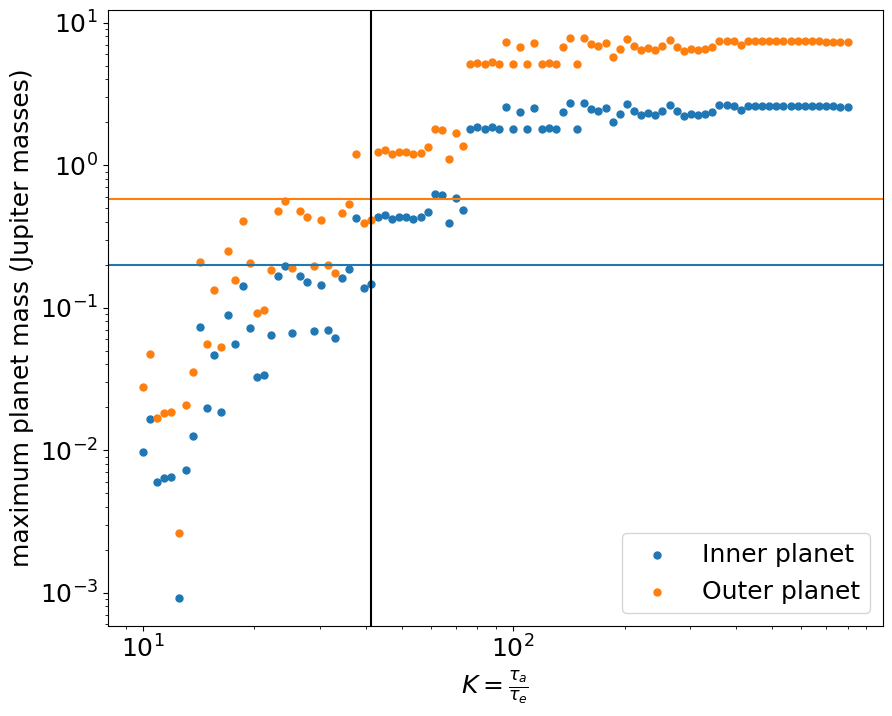

In [25]:
mass_sims_location = 'hd_max_mass_february_2024'  # folder that the ecc sims are in
nsims=100
Ks = np.geomspace(10, 800, nsims)
max_m1s, max_m2s = np.zeros(nsims), np.zeros(nsims)

for i in range(0, nsims):
    if not os.path.isfile(f'{mass_sims_location}/max_mass_archive_local_{i}.bin'):  # if simulationarchive doesn't exist just skip it
        continue
    mass_sim = rb.Simulation(f'{mass_sims_location}/max_mass_archive_local_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = mass_sim.particles[1]
    outer = mass_sim.particles[2]
    
    max_m1s[i] = inner.m * STAR_MASS  # inner and outer planet masses
    max_m2s[i] = outer.m * STAR_MASS

pl.figure(figsize = (10, 8))
pl.rc('font', size=18)
pl.scatter(Ks, max_m1s, label = 'Inner planet')
pl.scatter(Ks, max_m2s, label = 'Outer planet')
pl.xscale('log'), pl.yscale('log')
pl.xlabel(r'$K = \frac{\tau_a}{\tau_e}$'), pl.ylabel(r'maximum planet mass (Jupiter masses)')
# pl.ylim(-0.1, 7)
pl.legend(loc = 'lower right')
# median minimum masses
pl.axhline(np.median(m1 * sin_i), color='C0')
# pl.axhline(m1_best, color='C0')
pl.axhline(np.median(m2 * sin_i), color='C1')
# pl.xlim(left=9)
# pl.ylim(top=10)
# pl.axhline(m2_best, color='C1')
pl.axvline(Ks[np.where(max_m2s < np.median(m2 * sin_i))[-1][-1]], color='k')
# pl.savefig('paper_figures/max_mass_vs_K.png')

In [26]:
Ks[np.where(max_m2s < np.median(m2 * sin_i))[-1][-1]]

41.22305728219556

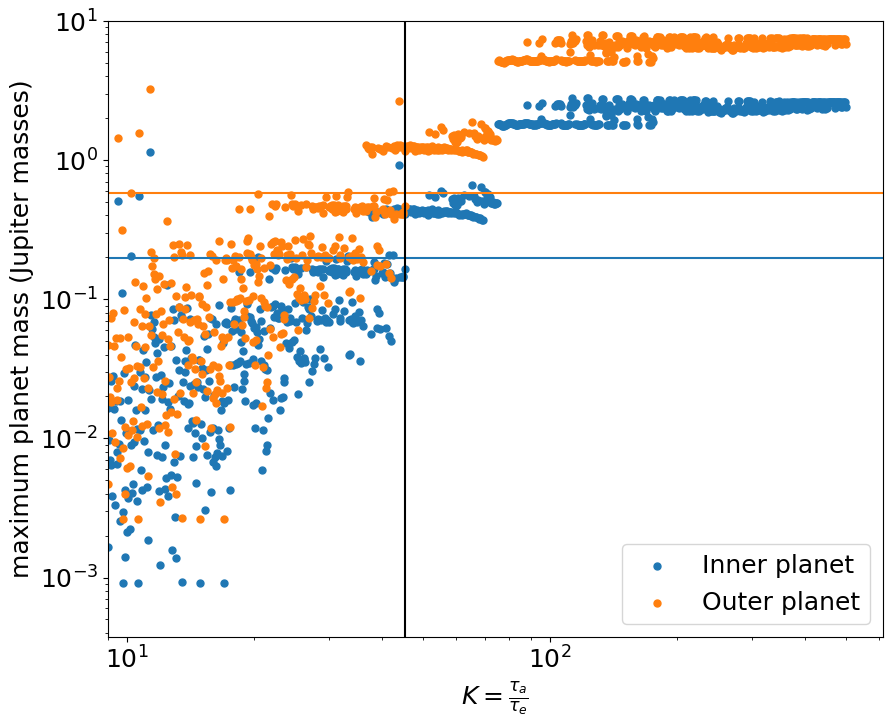

In [27]:
mass_sims_location = 'hd_max_mass_march_2024'  # folder that the ecc sims are in
nsims=1000
Ks = np.geomspace(9, 500, nsims)
max_m1s, max_m2s = np.zeros(nsims), np.zeros(nsims)
for i in range(0, nsims):
    if not os.path.isfile(f'{mass_sims_location}/max_mass_archive_local_{i}.bin'):  # if simulationarchive doesn't exist just skip it
        continue
    mass_sim = rb.Simulation(f'{mass_sims_location}/max_mass_archive_local_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    inner = mass_sim.particles[1]
    outer = mass_sim.particles[2]
    
    max_m1s[i] = inner.m * STAR_MASS  # inner and outer planet masses
    max_m2s[i] = outer.m * STAR_MASS

pl.figure(figsize = (10, 8))
pl.rc('font', size=18)
pl.scatter(Ks, max_m1s, label = 'Inner planet')
pl.scatter(Ks, max_m2s, label = 'Outer planet')
pl.xscale('log'), pl.yscale('log')
pl.xlabel(r'$K = \frac{\tau_a}{\tau_e}$'), pl.ylabel(r'maximum planet mass (Jupiter masses)')
# pl.ylim(-0.1, 7)
pl.legend(loc = 'lower right')
# median minimum masses
pl.axhline(np.median(m1 * sin_i), color='C0')
# pl.axhline(m1_best, color='C0')
pl.axhline(np.median(m2 * sin_i), color='C1')
pl.xlim(left=9)
pl.ylim(top=10)
# pl.axhline(m2_best, color='C1')
pl.axvline(Ks[np.where(max_m2s < np.median(m2 * sin_i))[-1][-1]], color='k')
# pl.savefig('paper_figures/max_mass_vs_K.png')

In [28]:
Ks[np.where(max_m2s < np.median(m2 * sin_i))[-1][-1]]

45.323667507742044

Suggest minimum value of approximately $K > 45$

### Convert posteriors to $K$ values:

Convert the $A = 0.1$ penalized posteriors to $K = \tau_a/\tau_e$ values using the semi-analytic Hamiltonian model with dissipative forces derived in summer 2022:

Import the $K$ values computed using the script:

In [29]:
posterior_K_values = np.load('../K_value_array_variable_01.npy')

In [30]:
np.mean(posterior_K_values), np.median(posterior_K_values)

(49.4361186492245, 45.20087601910968)

In [31]:
# 90%
np.quantile(posterior_K_values, [0.05, 0.95])

array([19.31068606, 94.53584628])

In [32]:
# 95%
np.quantile(posterior_K_values, [0.025, 0.975])

array([ 16.47635923, 105.70060068])

In [33]:
# 99%
np.quantile(posterior_K_values, [0.005, 0.995])

array([ 12.08639601, 128.37520601])

Compute and plot a nonparametric KDE with gaussian kernel for the $K$ distribution:

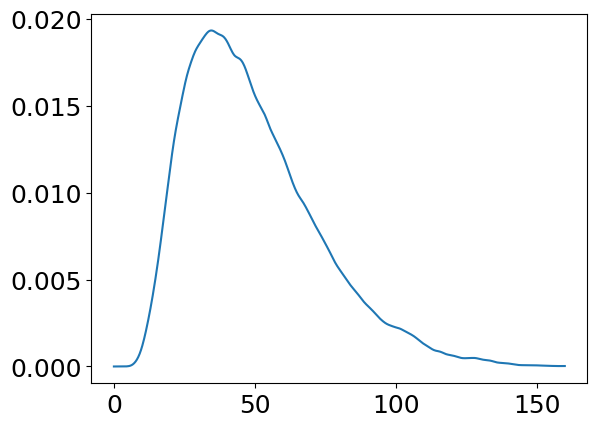

In [34]:
kde_xs = np.linspace(0, 160, int(1e3))
# this takes a while to run
gaussian_kde_Ks = stats.gaussian_kde(posterior_K_values.astype(np.float64))(kde_xs)
# plot
pl.plot(kde_xs, gaussian_kde_Ks)

#### Figure in paper; $K$ histogram

this should argue for what the maximum mass should be if we
forced the system to be exactly in resonance 
since K determines the equilibrium eccentricities as well as the 
maximum mass of the system, so max mass is dependnet on equilibrium
eccentricities
then consider the k range corresponding to the histogram in the above
maximum mass plot and make some conclusions on the maximum mass based on
that

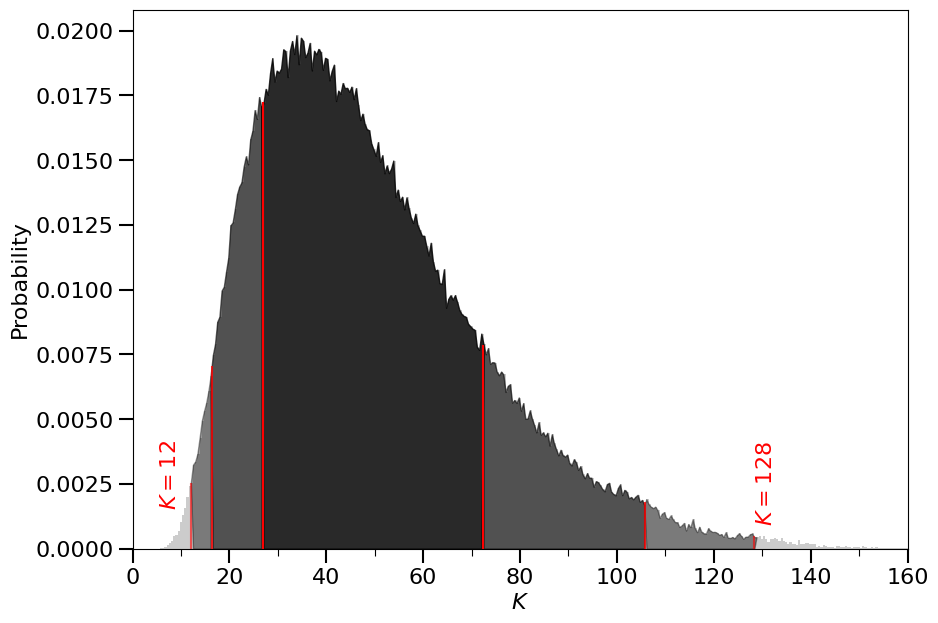

In [35]:
best_fit_K_value = 122.258  # take the best-fit value of K from posterior_to_K_single notebook

pl.rc('font', size=16)
# plot:
fig, ax = pl.subplots(figsize = (10, 7))
n, bins, _ = pl.hist(posterior_K_values.astype(np.float64), bins='auto', density=True, color='k', alpha=0.2)
np.median(posterior_K_values)
pl.xlim(0, 160)  # manually cut off right side at K = 160
pl.xlabel(r'$K$'), pl.ylabel('Probability')

alphas_vlines = [0.6, 0.8, 1., 1., 0.8, 0.6]
# vlines
ax.vlines(np.quantile(posterior_K_values, [0.005, 0.025, 0.160, 0.840, 0.975, 0.995]), ymin=0., 
          ymax=np.array([gaussian_kde_Ks[np.abs(kde_xs - np.quantile(posterior_K_values, value)).argmin()] 
                         for value in np.array([0.005, 0.025, 0.160, 0.840, 0.975, 0.995])]), 
          color='r', alpha = alphas_vlines)


# shading
alphas_shading = [0.4, 0.6, 0.8, 0.6, 0.4]
bounds = np.quantile(posterior_K_values, [0.005, 0.025, 0.160, 0.840, 0.975, 0.995])
colors=['gold', 'steelblue', 'purple', 'steelblue', 'gold']

# for left, right, color in zip(bounds, bounds[1:], colors):
#     ax.fill_between(bins[:-1], y1=n, where=(bins[:-1] >= left) & (bins[:-1] < right), color=color, interpolate=True)

# shade alternate
for left, right, alpha in zip(bounds, bounds[1:], alphas_shading):
    ax.fill_between(bins[:-1], y1=n, where=(bins[:-1] >= left) & (bins[:-1] < right), color='k', alpha=alpha, interpolate=True)
# # annotate credible interval, text placement is eyeballed
# # 99%
# pl.annotate(text=fr'$K = ${int(np.round(np.quantile(posterior_K_values, 0.005), 0))}', xy=(np.quantile(posterior_K_values, 0.005), np.max(n)), 
#             xycoords='data', textcoords='axes fraction', xytext=(0.035, 0.850), color='gold', ha='left', rotation=90)#, arrowprops=dict(facecolor='red', shrink=0.01), color='red')
# pl.annotate(text=fr'$K = ${int(np.round(np.quantile(posterior_K_values, 0.995), 0))}', xy=(np.quantile(posterior_K_values, 0.995), np.max(n)), 
#             xycoords='data', textcoords='axes fraction', xytext=(0.665, 0.840), color='gold', ha='left', rotation=90)#, arrowprops=dict(facecolor='red', shrink=0.01), color='red')
# # 95%
# pl.annotate(text=fr'$K = ${int(np.round(np.quantile(posterior_K_values, 0.025), 0))}', xy=(np.quantile(posterior_K_values, 0.025), np.max(n)), 
#             xycoords='data', textcoords='axes fraction', xytext=(0.055, 0.550), color='steelblue', ha='left', rotation=90)#, arrowprops=dict(facecolor='red', shrink=0.01), color='red')
# pl.annotate(text=fr'$K = ${int(np.round(np.quantile(posterior_K_values, 0.975), 0))}', xy=(np.quantile(posterior_K_values, 0.975), np.max(n)), 
#             xycoords='data', textcoords='axes fraction', xytext=(0.665, 0.840), color='steelblue', ha='left', rotation=90)#, arrowprops=dict(facecolor='red', shrink=0.01), color='red')
# # 68%
# pl.annotate(text=fr'$K = ${int(np.round(np.quantile(posterior_K_values, 0.160), 0))}', xy=(np.quantile(posterior_K_values, 0.160), np.max(n)), 
#             xycoords='data', textcoords='axes fraction', xytext=(0.105, 0.250), color='purple', ha='left', rotation=90)#, arrowprops=dict(facecolor='red', shrink=0.01), color='red')
# pl.annotate(text=fr'$K = ${int(np.round(np.quantile(posterior_K_values, 0.840), 0))}', xy=(np.quantile(posterior_K_values, 0.840), np.max(n)), 
#             xycoords='data', textcoords='axes fraction', xytext=(0.665, 0.840), color='purple', ha='left', rotation=90)#, arrowprops=dict(facecolor='red', shrink=0.01), color='red')

pl.annotate(text=fr'$K = ${int(np.round(np.quantile(posterior_K_values, 0.005), 0))}', xy=(np.quantile(posterior_K_values, 0.005), np.max(n)), 
            xycoords='data', textcoords='axes fraction', xytext=(0.035, 0.080), color='red', ha='left', rotation=90)#, arrowprops=dict(facecolor='red', shrink=0.01), color='red')
pl.annotate(text=fr'$K = ${int(np.round(np.quantile(posterior_K_values, 0.995), 0))}', xy=(np.quantile(posterior_K_values, 0.995), np.max(n)), 
            xycoords='data', textcoords='axes fraction', xytext=(0.805, 0.050), color='red', ha='left', rotation=90)#, arrowprops=dict(facecolor='red', shrink=0.01), color='red')

ax.set_xticks(np.linspace(0., 160., 17), minor=True)
ax.tick_params('both', length=10, width=1.5, which='major')
ax.tick_params('both', length=5, width=0.8, which='minor')

# save figure
pl.savefig('paper_figures/K_histogram_large_penalty.png')

(0.0, 200.0)

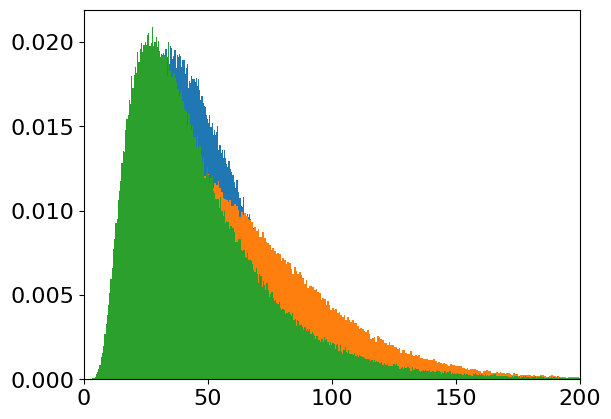

In [36]:
pl.hist(np.load('../K_value_array_variable_01.npy').astype(np.float64), bins='auto', density=True)  # A = 0.1 (strong penalty)
pl.hist(np.load('K_value_array_libration_penalty1.npy').astype(np.float64), bins='auto', density=True)  # I have no idea what penalty this is??? A = 0.3???
pl.hist(np.load('K_value_array_unpenalized.npy').astype(np.float64), bins='auto', density=True)  # no penalty
pl.xlim(0, 200)

(0.0, 400.0)

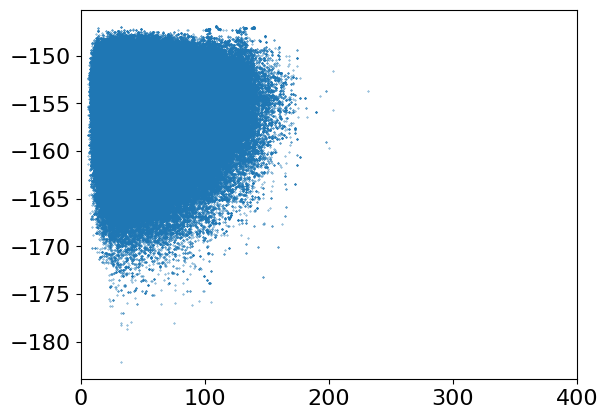

In [37]:
pl.scatter(posterior_K_values, log_prob.reshape(-1), s=0.1)
pl.xlim(0, 400)

In [38]:
np.quantile(posterior_K_values, [0.05, 0.5, 0.95])

array([19.31068606, 45.20087602, 94.53584628])

### Get full MCMC chains/posteriors for different $A$-penalties:

Get the full MCMC chains and posteriors for libration penalty $A = [0.1,\dots,1]$ to see how they compare with the $A = 0.3$ we used first, using new lower bounds on $\sin(i)$ determined from the maximum planet mass calculations

We have the posteriors for median values of $m\sin(i)$, as well as maximum values for $m$. We can use this to solve for the maximum $\sin(i)$ possible, taking the minimum mass $m\sin(i)$ to be the median posterior value. 

NOTE: ignoring the oddly high maximum stable masses around $3 < K < 9$ ish...

(0.0827811565245746, 0.08503891748982578)

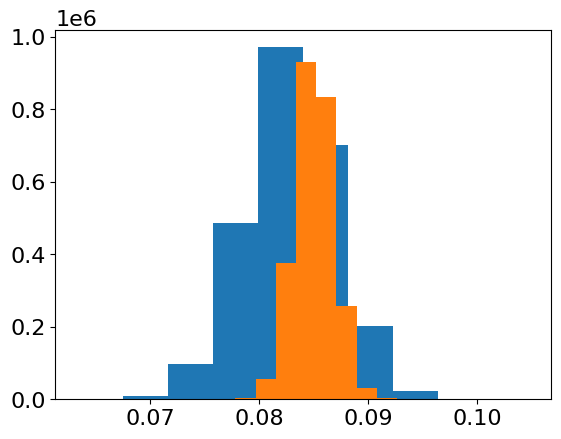

In [39]:
m1sini = m1 * sin_i
m2sini = m2 * sin_i

pl.hist(m1sini.reshape(-1)/max_m1s[-1])
pl.hist(m2sini.reshape(-1)/max_m2s[-1])

np.mean(m1sini.reshape(-1)/max_m1s[-1]), np.mean(m2sini.reshape(-1)/max_m2s[-1])

So minimum $\sin(i)$ could be set at around $\sim 0.076$ for our chains...

Importing one of the chains (with $A = 0.1$) and removing burnin to check it:

In [40]:
variable_data_1 = h5py.File('../mcmc_hd45364_everything_with_libration_penalty_variable_1.h5', 'r')  # import data
accepted_1, samples_1, log_prob_1 = np.array(variable_data_1['mcmc']['accepted']), np.array(variable_data_1['mcmc']['chain']), np.array(variable_data_1['mcmc']['log_prob'])

# removing burnin:

accepted_1 = accepted_1[burnin:]
samples_1 = samples_1[burnin:]
log_prob_1 = log_prob_1[burnin:]

# truncating samples and log_prob if they're not exactly 50000 steps
samples_1 = samples_1[~np.all(samples_1 == 0, axis=2)]
samples_1 = samples_1.reshape(int(samples_1.shape[0]/50), 50, samples_1.shape[-1])

log_prob_1 = log_prob_1[~np.all(log_prob_1 == 0, axis = 1)]

Plotting inner/outer chains:

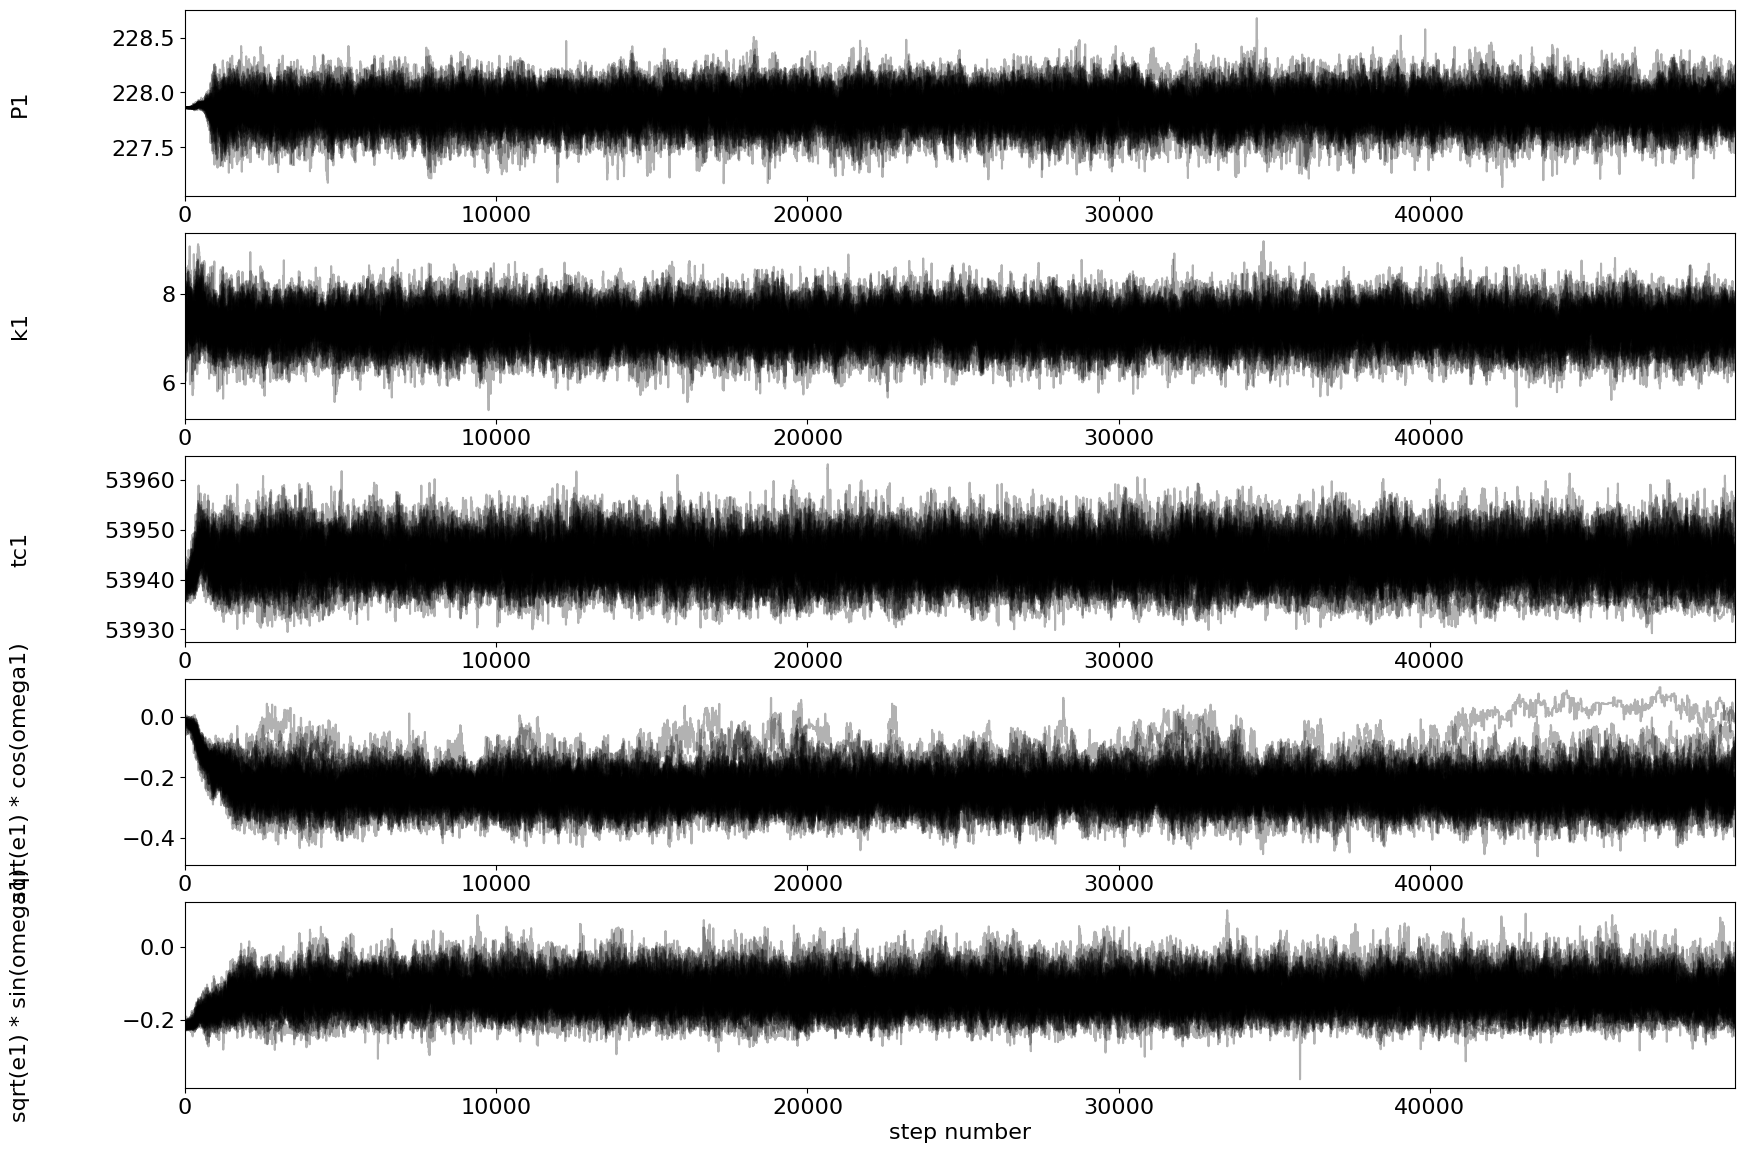

In [41]:
_, axes = pl.subplots(5, figsize=(20, 14))
labels1 = ['P1', 'k1', 'tc1', 'sqrt(e1) * cos(omega1)', 'sqrt(e1) * sin(omega1)']

for i in range(5):
    ax = axes[i]
    ax.plot(samples_1[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples_1))
    ax.set_ylabel(labels1[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

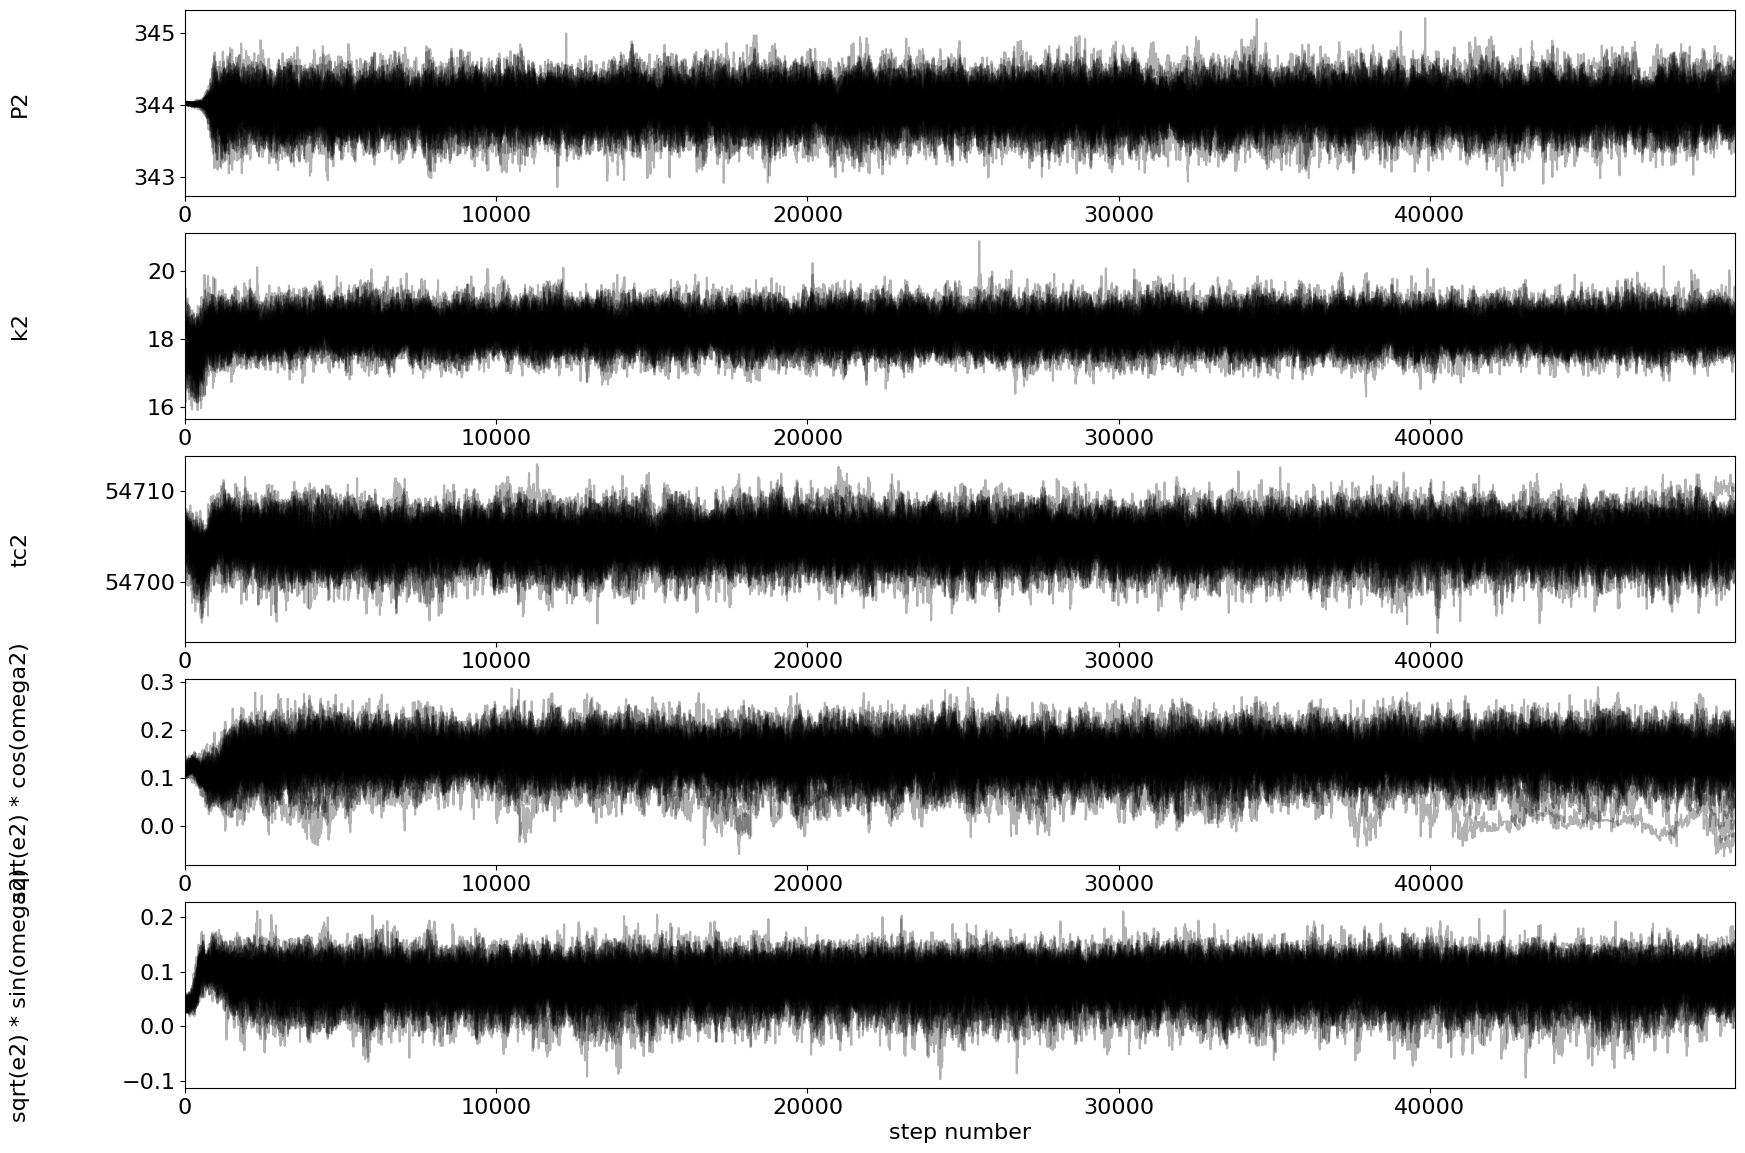

In [42]:
_, axes = pl.subplots(5, figsize=(20, 14))
labels2 = ['P2', 'k2', 'tc2', 'sqrt(e2) * cos(omega2)', 'sqrt(e2) * sin(omega2)']

for i in range(5, 10):
    ax = axes[i - 5]
    ax.plot(samples_1[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples_1))
    ax.set_ylabel(labels2[i - 5])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");

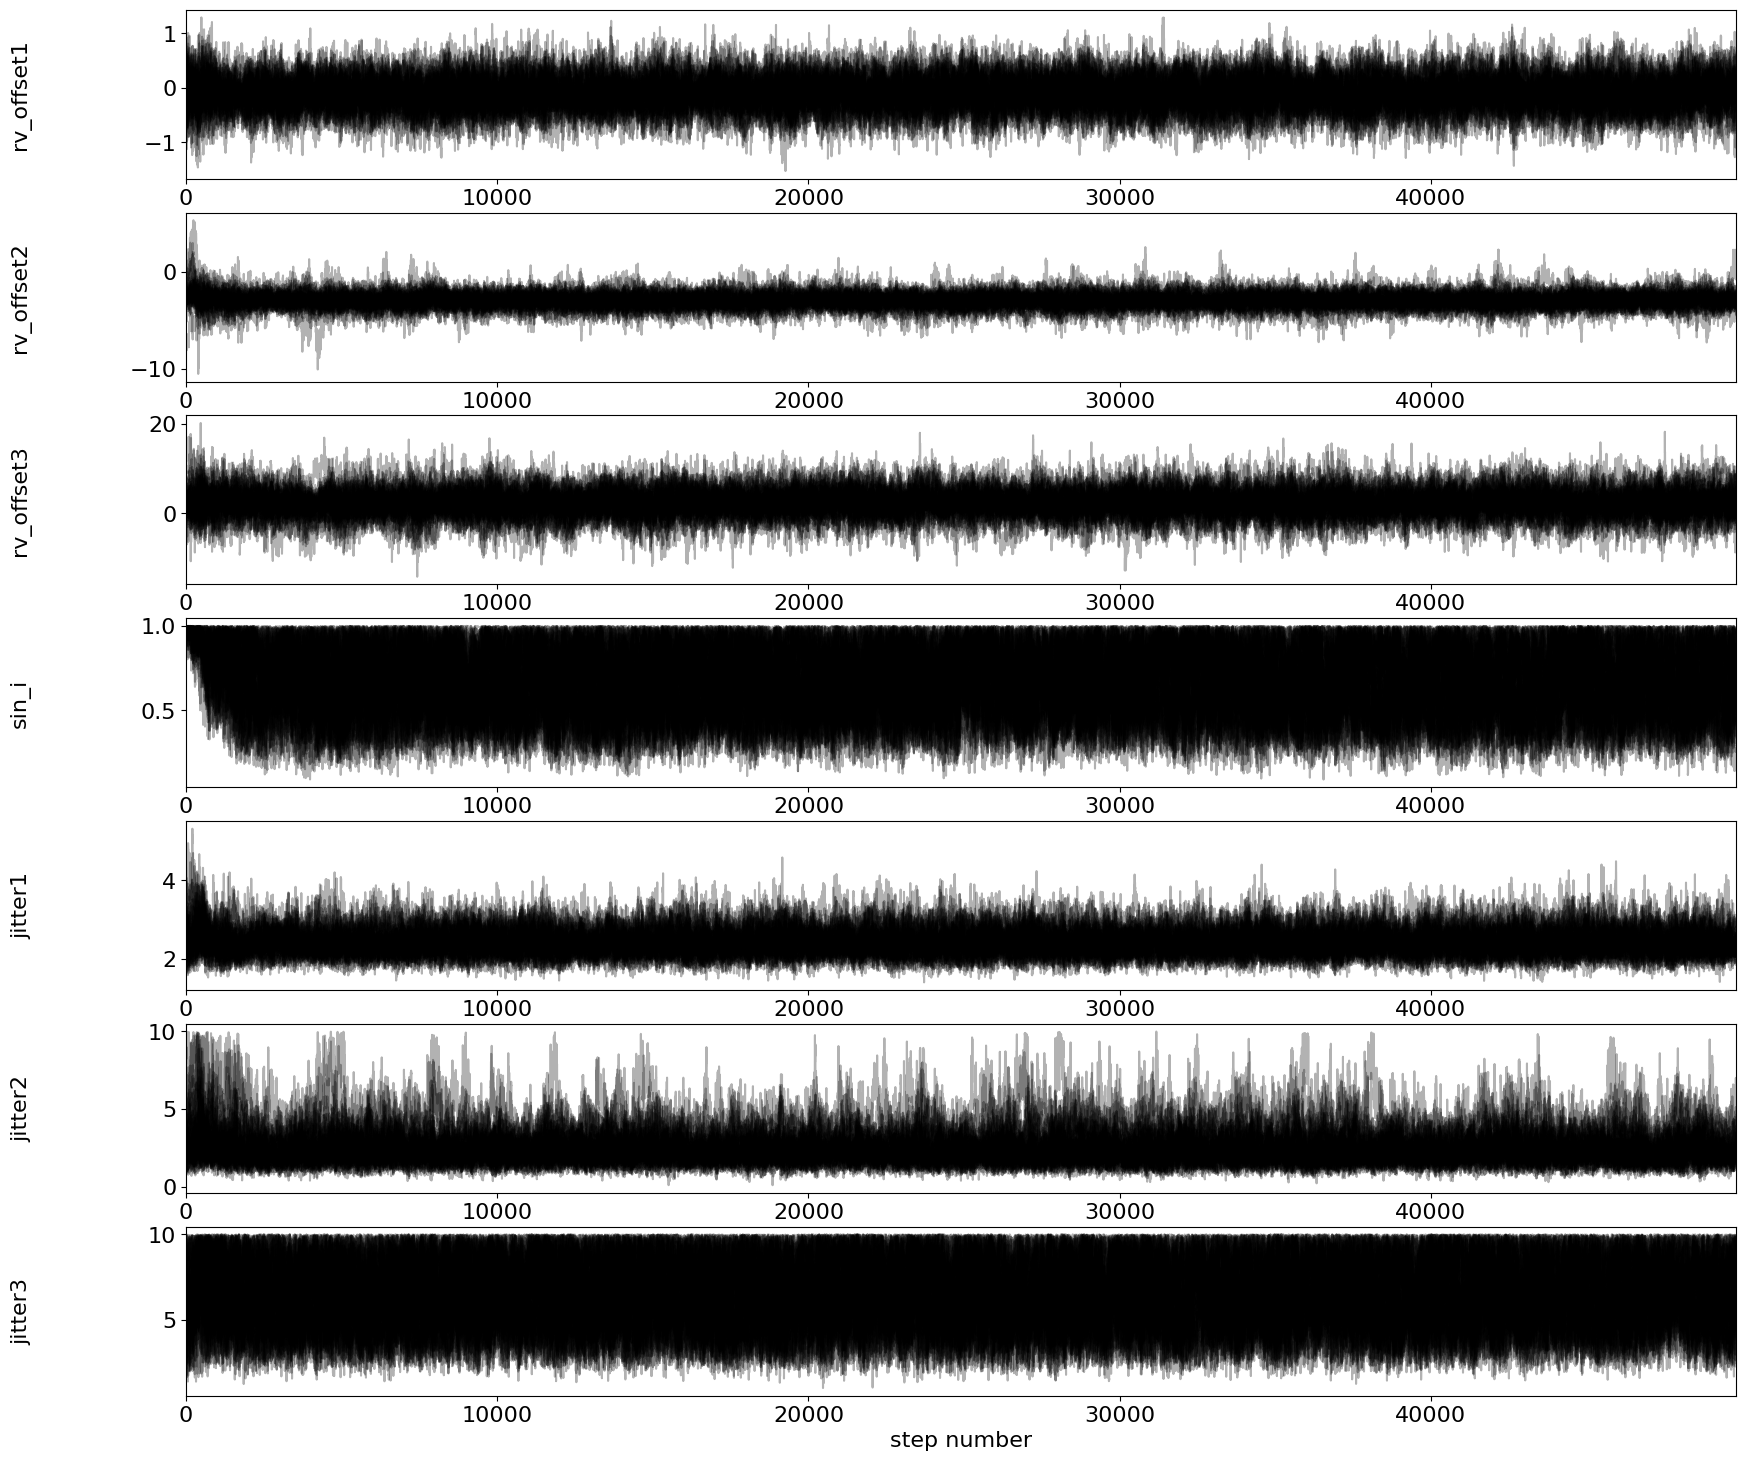

In [43]:
_, axes = pl.subplots(7, figsize=(20, 18))
labels3 = ['rv_offset1', 'rv_offset2', 'rv_offset3', 'sin_i', 'jitter1', 'jitter2', 'jitter3']
for i in range(10, 17):
    ax=axes[i - 10]
    ax.plot(samples_1[:, :, i], 'k', alpha = 0.3)
    ax.set_xlim(0, len(samples_1))
    ax.set_ylabel(labels3[i - 10])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number");
        
# pl.figure(figsize = (20, 4))
# pl.plot(samples[:, :, 10], 'k', alpha = 0.3)
# pl.xlim(0, len(samples))
# pl.xlabel('step number'), pl.ylabel('rv_offset')

Posterior distribution of orbital elements:

In [44]:
e1 = samples_1[:, :, 3] ** 2 + samples_1[:, :, 4] ** 2  # computing eccentricity
e2 = samples_1[:, :, 8] ** 2 + samples_1[:, :, 9] ** 2  # computing eccentricity
p1 = samples_1[:, :, 0]
k1 = samples_1[:, :, 1]
p2 = samples_1[:, :, 5]
k2 = samples_1[:, :, 6]
tc1 = samples_1[:, :, 2]
tc2 = samples_1[:, :, 7]
omega1 = np.arctan2(samples_1[:, :, 3], samples_1[:, :, 4])  # omega is argument of periapsis
omega2 = np.arctan2(samples_1[:, :, 8], samples_1[:, :, 9])

rv_offset1 = samples_1[:, :, 10]  # rv_offset
rv_offset2 = samples_1[:, :, 11]  # rv_offset
rv_offset3 = samples_1[:, :, 12]  # rv_offset
sin_i = samples_1[:, :, 13] # sin_i
jitter1 = samples_1[:, :, 14]
jitter2 = samples_1[:, :, 15]
jitter3 = samples_1[:, :, 16]

 # print(k1.shape, p1.shape, e1.shape)

m1 = semiamp_to_mass(k1/(AUDAY_MS), STAR_MASS, p1, e1, inclination = np.arcsin(sin_i))
m2 = semiamp_to_mass(k2/(AUDAY_MS), STAR_MASS, p2, e2, inclination = np.arcsin(sin_i))
# print(m1.shape, e1.shape, m2.shape, e1.shape)

In [45]:
pd.DataFrame(data=[np.quantile(m1.reshape(-1), [0.05, 0.5, 0.95]), 
                   np.quantile(p1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(e1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(tc1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(omega1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(m2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(p2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(e2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(tc2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(omega2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(rv_offset1.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(rv_offset2.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(rv_offset3.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(sin_i.reshape(-1), [0.05, 0.5, 0.95]),
                   np.quantile(jitter1.reshape(-1), [0.01, 0.5, 0.95]),
                   np.quantile(jitter2.reshape(-1), [0.01, 0.5, 0.95]), 
                   np.quantile(jitter3.reshape(-1), [0.01, 0.5, 0.95])
                  ], index = ['m1', 'p1', 'e1', 'tc1', 'omega1', 
                              'm2', 'p2', 'e2', 'tc2', 'omega2', 
                              'rv_offset1', 'rv_offset2', 'rv_offset3',
                              'sin_i',
                              'jitter1', 'jitter2', 'jitter3'], 
             columns=['5%', '50%', '95%'])

5%           50%           95%
m1              0.204355      0.294218      0.570299
p1            227.634731    227.858272    228.069787
e1              0.048929      0.072308      0.111744
tc1         53937.687119  53943.782495  53949.912044
omega1         -2.508737     -2.065039     -1.760272
m2              0.592969      0.850376      1.655121
p2            343.630893    343.994547    344.342468
e2              0.017452      0.027197      0.044151
tc2         54701.604810  54704.537044  54707.471173
omega2          0.601003      1.051174      1.400617
rv_offset1     -0.546129     -0.102110      0.345573
rv_offset2     -4.042118     -2.921810     -1.808311
rv_offset3     -1.984306      2.328474      6.680965
sin_i           0.351800      0.678705      0.968590
jitter1         1.832006      2.400386      2.958952
jitter2         1.003137      2.270734      4.210615
jitter3         2.718188      6.431801      9.550185

Make some plots to visualize:

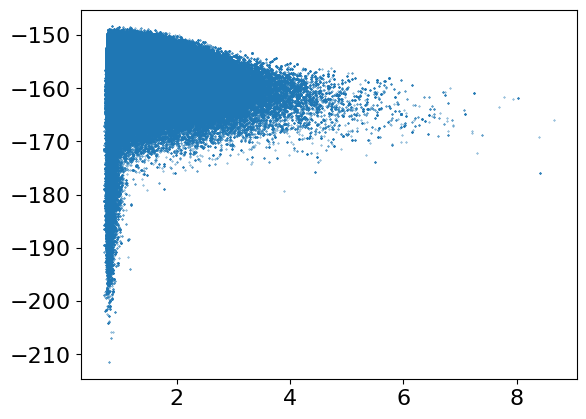

In [46]:
total_mass = m1.reshape(-1) + m2.reshape(-1)
sin_is = sin_i.reshape(-1)

pl.scatter(total_mass, log_prob_1.reshape(-1), s=0.1)  # sin(i) doesn't seem to affect it so much anymore when I add in jitter... why????
# pl.xlim(0.5, 3)

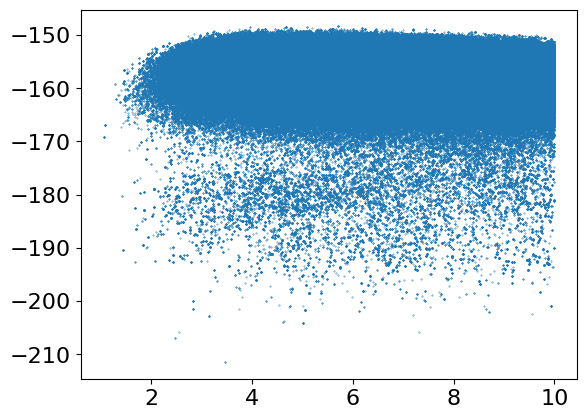

In [47]:
pl.scatter(samples_1.reshape(-1, 17)[:,-1], log_prob_1.reshape(-1), s=0.1)

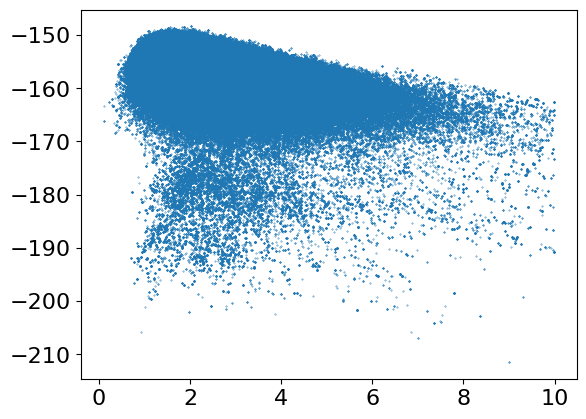

In [48]:
pl.scatter(samples_1.reshape(-1, 17)[:,-2], log_prob_1.reshape(-1), s=0.1)  # sin(i) doesn't seem to affect it so much anymore when I add in jitter... why????
# pl.ylim(-175, -145)

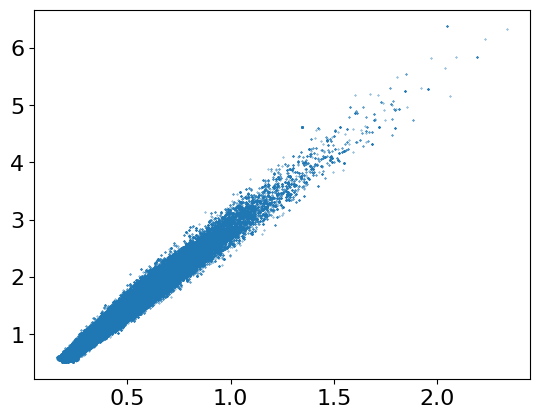

In [49]:
pl.scatter(m1.reshape(-1), m2.reshape(-1), s=0.1)

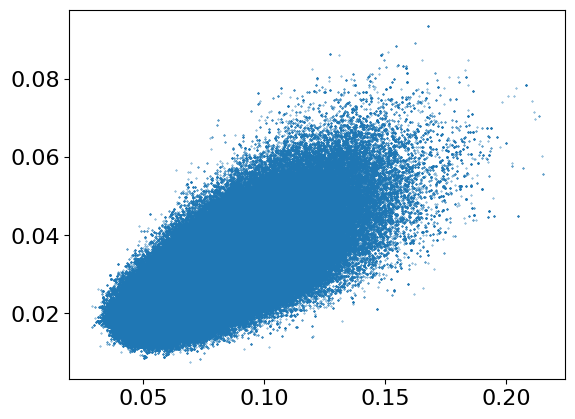

In [50]:
pl.scatter(e1.reshape(-1), e2.reshape(-1), s=0.1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


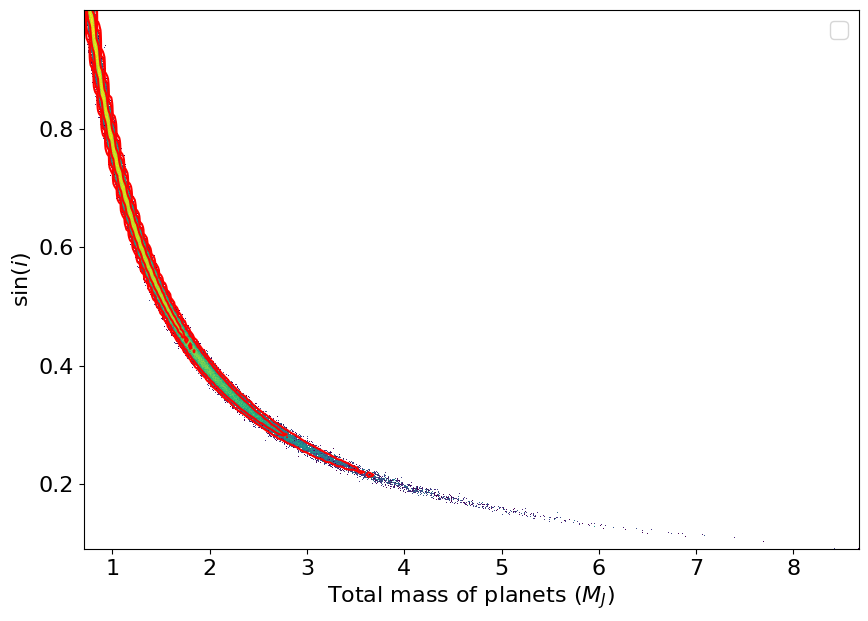

In [51]:
import matplotlib as mpl

pl.figure(figsize = (10, 7))
# contour lines
corner.hist2d(total_mass, sin_is, s=0.1, bins=200, plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='r', label = 'Contours')
# histogram with log norm
pl.hist2d(total_mass, sin_is, norm=mpl.colors.LogNorm(), bins=1000)  # log norm
# pl.scatter(m1_best + m2_best, sini_best, color = 'black', label ='Best fit', s=100)  # best-fit point
# pl.scatter(m1sini_tail + m2sini_tail, sini_tail, color = 'orange', label = 'Tail point', s=100)  # fit for a tail point
pl.xlabel(r'Total mass of planets ($M_J$)'), pl.ylabel(r'$\sin(i)$')
# pl.annotate(fr'$ \log L \approx {np.round(neg_log_likelihood(best), 2)}$', 
#             xy=(m1_best/sini_best + m2_best/sini_best, sini_best), 
#             xycoords='data', 
#             textcoords='axes fraction', xytext=(0.15, 0.95), color='black')#, arrowprops=dict(facecolor='red', shrink=0.01), color ='red')
# pl.annotate(fr'$ \log L \approx {np.round(neg_log_likelihood(flat_samples[tail_index]), 2)}$', 
#             xy=(m1sini_tail/sini_tail + m2sini_tail/sini_tail, sini_tail), 
#             xycoords='data', 
#             textcoords='axes fraction', xytext=(0.75, 0.1), color='orange')#, arrowprops=dict(facecolor='red', shrink=0.01), color ='red')

# pl.annotate(fr'$K \approx {int(np.round(K_dist_bounds[0], roundto))}$', xy=(np.max(e1_dist), np.max(e2_dist)), xycoords='data', 
#             textcoords='axes fraction', xytext=(0.8, 0.8), arrowprops=dict(facecolor='red', shrink=0.01), color ='red')
# x limit
# pl.xlim(right=1.1)
# pl.ylim(bottom=0.3)
pl.legend()
# pl.savefig('sin_i_mtot_dist.png')#, fmt='png')

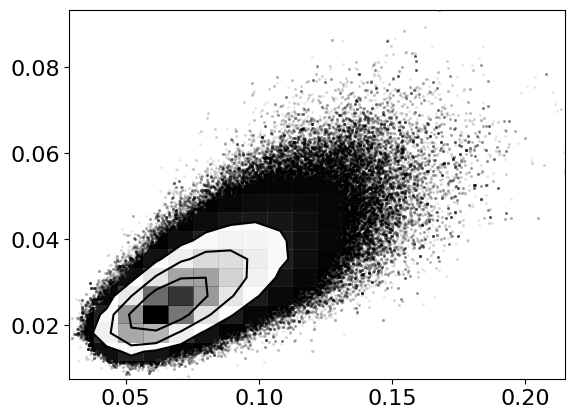

In [52]:
corner.hist2d(e1.reshape(-1), e2.reshape(-1))

## March 2024:

Plot the eccentricity posteriors/constraints for unconstrained, intermediate and strong constraints:

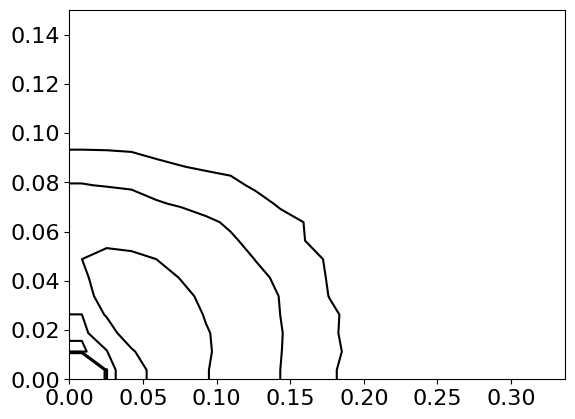

In [53]:
samples_8 = np.array(h5py.File('../mcmc_hd45364_everything_with_libration_penalty_variable_0.h5', 'r')['mcmc']['chain'])[burnin:]
e1s_8 = samples_8[:, :, 3] ** 2 + samples_8[:, :, 4] ** 2  # computing eccentricity
e2s_8 = samples_8[:, :, 8] ** 2 + samples_8[:, :, 9] ** 2
corner.hist2d(e1s_8.reshape(-1), e2s_8.reshape(-1), s=0.1, bins=20, plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99])

Use `getDist` to generate nice contours:

In [54]:
def get_penalized_es(penalty, burnin=burnin):
    """
    Gets the penalized e1, e2 values for libration penalty penalty
    param penalty: last digit of the A penalty (e.g. penalty=1 corresponds to A = 0.1, penalty=0 corresponds to A = 1.0) between A = 0.1 and A = 1.0
    param burnin: number of burnin steps to remove from the beginning of the chains

    returns tuple of (penalized_e1s, penalized_e2s) that have been flattened
    """
    penalized_samples = np.array(h5py.File(f'../mcmc_hd45364_everything_with_libration_penalty_variable_{penalty}.h5', 'r')['mcmc']['chain'])[burnin:]  # import data
    # truncating samples and log_prob if they're not exactly 50000 steps
    penalized_samples = penalized_samples[~np.all(penalized_samples == 0, axis=2)]
    penalized_samples = penalized_samples.reshape(int(penalized_samples.shape[0]/50), 50, penalized_samples.shape[-1])
    # compute e1 and e2
    penalized_e1s = penalized_samples[:, :, 3] ** 2 + penalized_samples[:, :, 4] ** 2  # computing eccentricity
    penalized_e2s = penalized_samples[:, :, 8] ** 2 + penalized_samples[:, :, 9] ** 2

    return penalized_e1s.reshape(-1), penalized_e2s.reshape(-1)

Removed no burn in
Removed no burn in


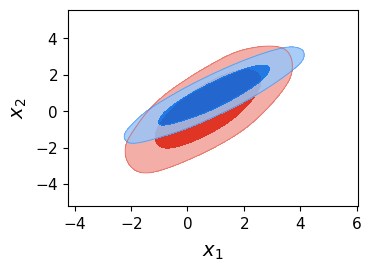

In [55]:
from getdist import gaussian_mixtures

samples1, samples2 = gaussian_mixtures.randomTestMCSamples(ndim=4, nMCSamples=2)
g = plots.get_single_plotter(width_inch = 4)
g.plot_2d([samples1,samples2], 'x1', 'x2', filled=True);

#### Figure in paper; $e_1$ - $e_2$ posterior contours for strong (0.1), intermediate (0.5), weak (1.0) penalties

$e_1$-$e_2$ posterior contours generated from the chains for strong, intermediate and weak libration penalties, which were generated using a log-likelihood function including all planet parameters and a jitter term (as for the unpenalized chains), but in this case also including an additional penalty term for RMS libration amplitude added to the unpenalized log-likelihood term

Results show that strong penalties produce tighter eccentricity distribution since it forces the system to be closer to perfect resonance -- shrinks towards the equilibrium eccentricity values for a system that would be perfectly in resonance

Removed no burn in
Removed no burn in
Removed no burn in


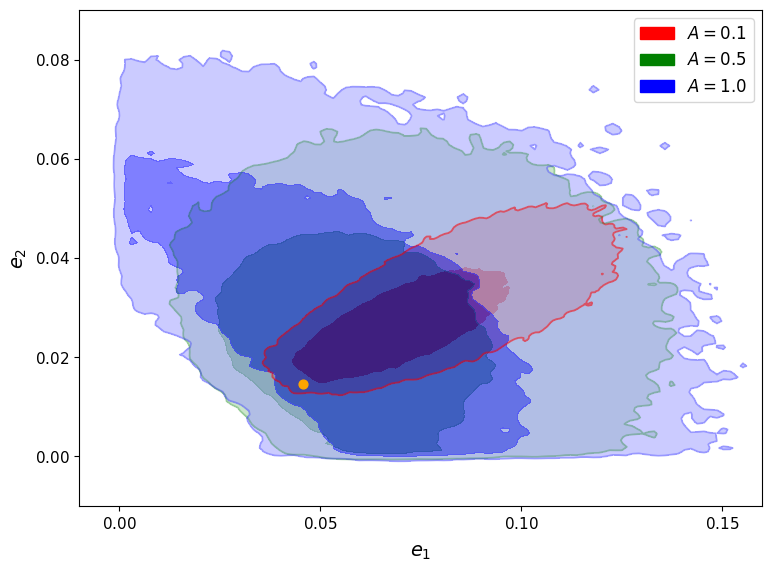

In [56]:
# plot contours for A_lib = [0.1, 0.5, 0.8] (weak, intermediate, strong constraints) 
penalties = [1, 5, 0]
# penalties = [1, 0]

# get the penalty list:
penalized_list = []
for penalty in penalties:
    penalized_mc_samples = MCSamples(samples=np.transpose(np.array(get_penalized_es(penalty))), names = [r'e_1', r'e_2'], labels = [r'e_1', r'e_2'])
    penalized_mc_samples.updateSettings({'contours': [0.68, 0.95]})#, 0.98]})
    penalized_list.append(penalized_mc_samples)

# plotting
g = plots.get_single_plotter(width_inch=8)
g.settings.num_plot_contours = 3
g.settings.alpha_filled_add=0.5
# g.settings.axis_tick_step_groups=[[1, 2, 5, 10], [2.5, 3, 4, 6, 8], [1.5, 7, 9]]
g.plot_2d(penalized_list, r'e_1', r'e_2', filled=True, shaded=True, colors=['r', 'g', 'b'])
g.set_axes().set_xticks([0., 0.05, 0.1, 0.15, 0.2])
g.set_axes().set_xlim(-0.01, 0.16)
g.set_axes().set_ylim(-0.01, 0.09)
# best-fit eccentricity
pl.scatter(e1_best, e2_best, s=40, c = 'orange', label = 'Best fit')  # best fit eccentricity
pl.legend()
# legend
g.add_legend(legend_labels = [r'$A = 0.1$', r'$A = 0.5$', r'$A = 1.0$'])
# legend
pl.savefig('paper_figures/e1_e2_contours_variable_libration_penalties.png')

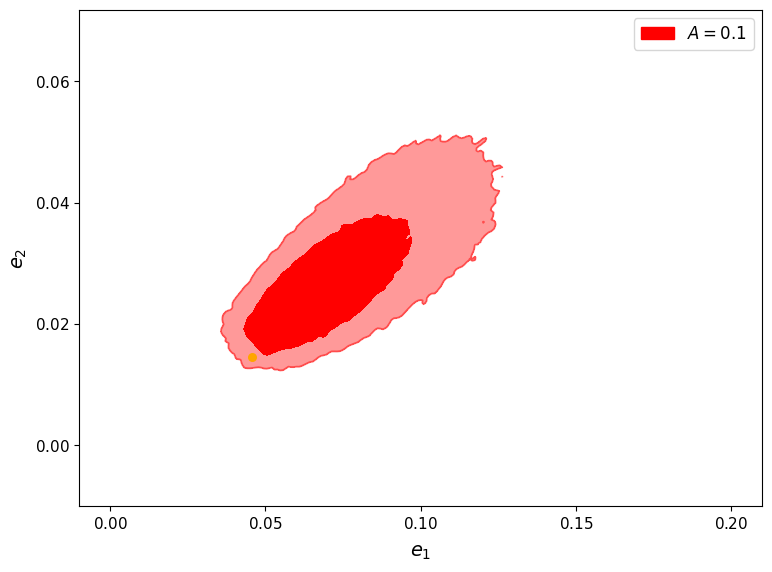

In [57]:
g1 = plots.get_single_plotter(width_inch=8)
g1.settings.num_plot_contours = 3
g1.settings.alpha_filled_add=0.5
# g.settings.axis_tick_step_groups=[[1, 2, 5, 10], [2.5, 3, 4, 6, 8], [1.5, 7, 9]]
g1.plot_2d(penalized_list[0], r'e_1', r'e_2', filled=True, shaded=True, colors=['r'])
g1.set_axes().set_xticks([0., 0.05, 0.1, 0.15, 0.2])
g1.set_axes().set_xlim(-0.01, 0.21)
g1.set_axes().set_ylim(bottom=-0.01)
# best-fit eccentricity
pl.scatter(e1_best, e2_best, s=30, c = 'orange', label = 'Best fit')  # best fit eccentricity
pl.legend()
# legend
g1.add_legend(legend_labels = [r'$A = 0.1$'])
# legend
# pl.savefig('paper_figures/e1_e2_contours_variable_libration_penalties.png')

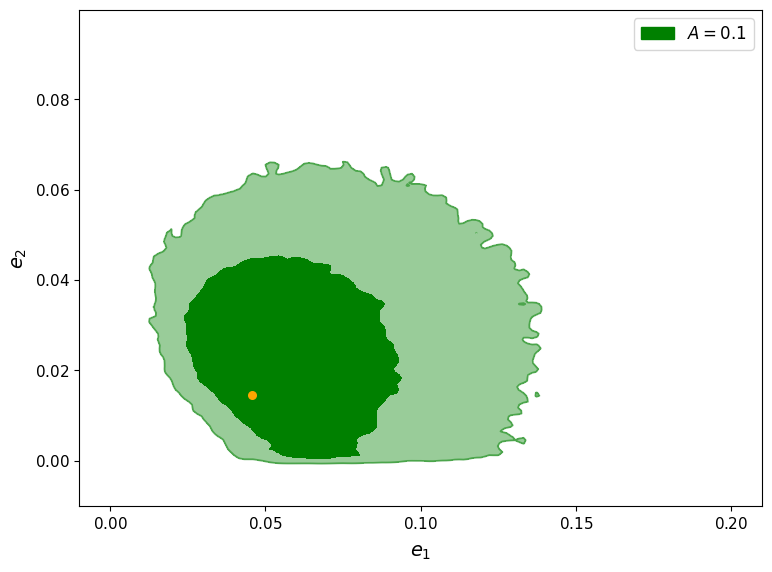

In [58]:
g2 = plots.get_single_plotter(width_inch=8)
g2.settings.num_plot_contours = 3
g2.settings.alpha_filled_add=0.5
# g.settings.axis_tick_step_groups=[[1, 2, 5, 10], [2.5, 3, 4, 6, 8], [1.5, 7, 9]]
g2.plot_2d(penalized_list[1], r'e_1', r'e_2', filled=True, shaded=True, colors=['g'])
g2.set_axes().set_xticks([0., 0.05, 0.1, 0.15, 0.2])
g2.set_axes().set_xlim(-0.01, 0.21)
g2.set_axes().set_ylim(bottom=-0.01)
# best-fit eccentricity
pl.scatter(e1_best, e2_best, s=30, c = 'orange', label = 'Best fit')  # best fit eccentricity
pl.legend()
# legend
g2.add_legend(legend_labels = [r'$A = 0.1$'])
# legend
# pl.savefig('paper_figures/e1_e2_contours_variable_libration_penalties.png')

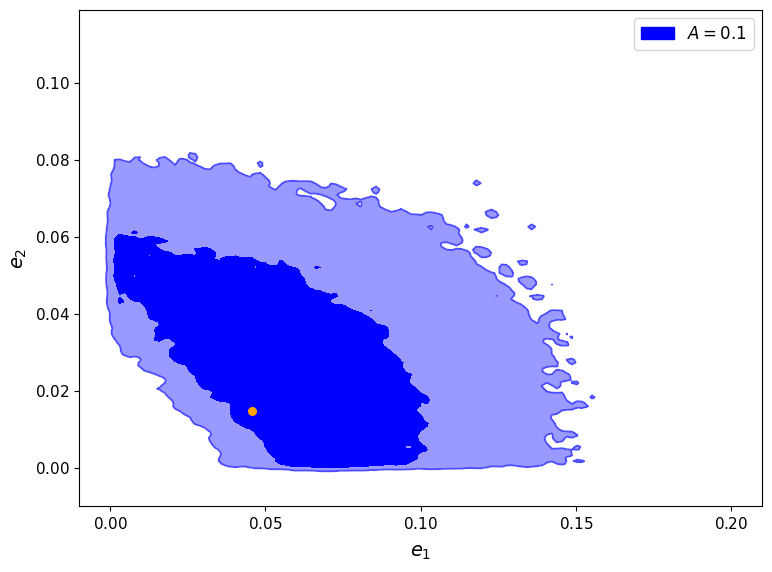

In [59]:
g3 = plots.get_single_plotter(width_inch=8)
g3.settings.num_plot_contours = 3
g3.settings.alpha_filled_add=0.5
# g.settings.axis_tick_step_groups=[[1, 2, 5, 10], [2.5, 3, 4, 6, 8], [1.5, 7, 9]]
g3.plot_2d(penalized_list[2], r'e_1', r'e_2', filled=True, shaded=True, colors=['b'])
g3.set_axes().set_xticks([0., 0.05, 0.1, 0.15, 0.2])
g3.set_axes().set_xlim(-0.01, 0.21)
g3.set_axes().set_ylim(bottom=-0.01)
# best-fit eccentricity
pl.scatter(e1_best, e2_best, s=30, c = 'orange', label = 'Best fit')  # best fit eccentricity
pl.legend()
# legend
g3.add_legend(legend_labels = [r'$A = 0.1$'])
# legend
# pl.savefig('paper_figures/e1_e2_contours_variable_libration_penalties.png')

#### Figure in paper; $e_1$ - $e_2$ posterior contours for unpenalized chains

replace the unpenalized e1-e2 posterior contours since we now take into account jitter and sini which we didn't before, this is going to be for the new plot with the eccentricity track with different $K$ values...

Removed no burn in


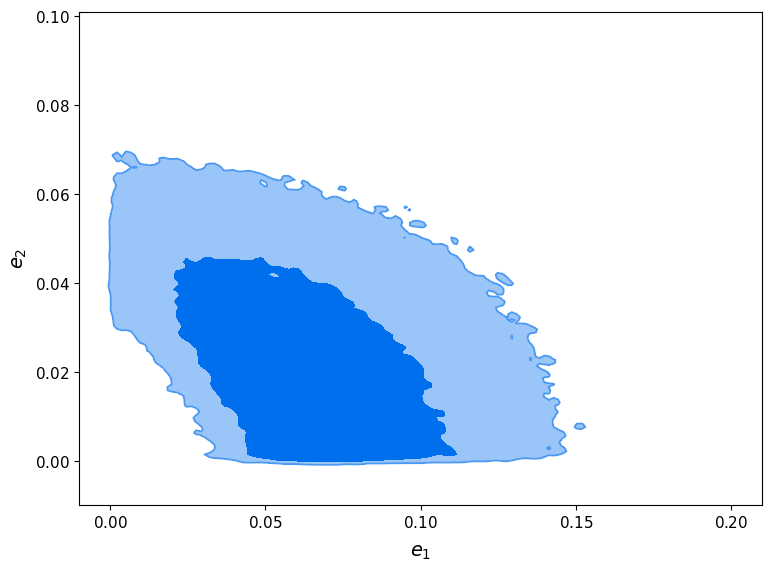

In [60]:
unpenalized_samples = np.array(h5py.File(f'../mcmc_hd45364_cluster_everything.h5', 'r')['mcmc']['chain'])[burnin:]
# truncating if required
unpenalized_samples = unpenalized_samples[~np.all(unpenalized_samples == 0, axis=2)]
unpenalized_samples = unpenalized_samples.reshape(int(unpenalized_samples.shape[0]/50), 50, unpenalized_samples.shape[-1])
# compute e1, e2
unpenalized_e1s = unpenalized_samples[:, :, 3] ** 2 + unpenalized_samples[:, :, 4] ** 2  # computing ecc
unpenalized_e2s = unpenalized_samples[:, :, 8] ** 2 + unpenalized_samples[:, :, 9] ** 2

unpenalized_mc_samples = MCSamples(samples = np.transpose(np.array((unpenalized_e1s.reshape(-1), unpenalized_e2s.reshape(-1)))), names = [r'e_1', r'e_2'], labels = [r'e_1', r'e_2'])
unpenalized_mc_samples.updateSettings({'contours': [0.68, 0.95]})#, 0.99]})

g3 = plots.get_single_plotter(width_inch = 8)
g3.settings.num_plot_contours = 3
g3.plot_2d(unpenalized_mc_samples, r'e_1', r'e_2', shaded=True, filled=True)
g3.set_axes().set_xticks([0., 0.05, 0.1, 0.15, 0.2])
g3.set_axes().set_xlim(-0.01, 0.21)
g3.set_axes().set_ylim(bottom=-0.01)
pl.savefig('paper_figures/e1_e2_unpenalized.png')

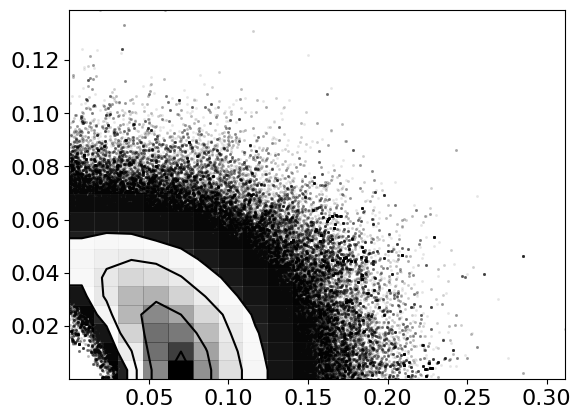

In [61]:
corner.hist2d(unpenalized_e1s.reshape(-1), unpenalized_e2s.reshape(-1))

In [62]:
# penalized_mc_samples = MCSamples(samples=np.transpose(np.array(get_penalized_es(5))), names = [r'e_1', r'e_2'], labels = [r'e_1', r'e_2'])
# penalized_mc_samples.updateSettings({'contours': [0.68, 0.95, 0.99]})

# # plotting using getDist
# g2 = plots.get_single_plotter(width_inch=6)
# g2.settings.num_plot_contours = 3
# g2.plot_2d(penalized_mc_samples, r'e_1', r'e_2', shaded=True, filled=True)
# # plt.savefig('4d_marginalized_cornerplot_nested_contours.png')#, fmt='png')
# pl.show()

#### Figure in paper; RV signal of old (H&P) and new (our analysis) fits 

Optimizing parameters using the negative log-likelihood as earlier in the notebook (using `best`), unpenalized with $\sin(i)$ and jitter

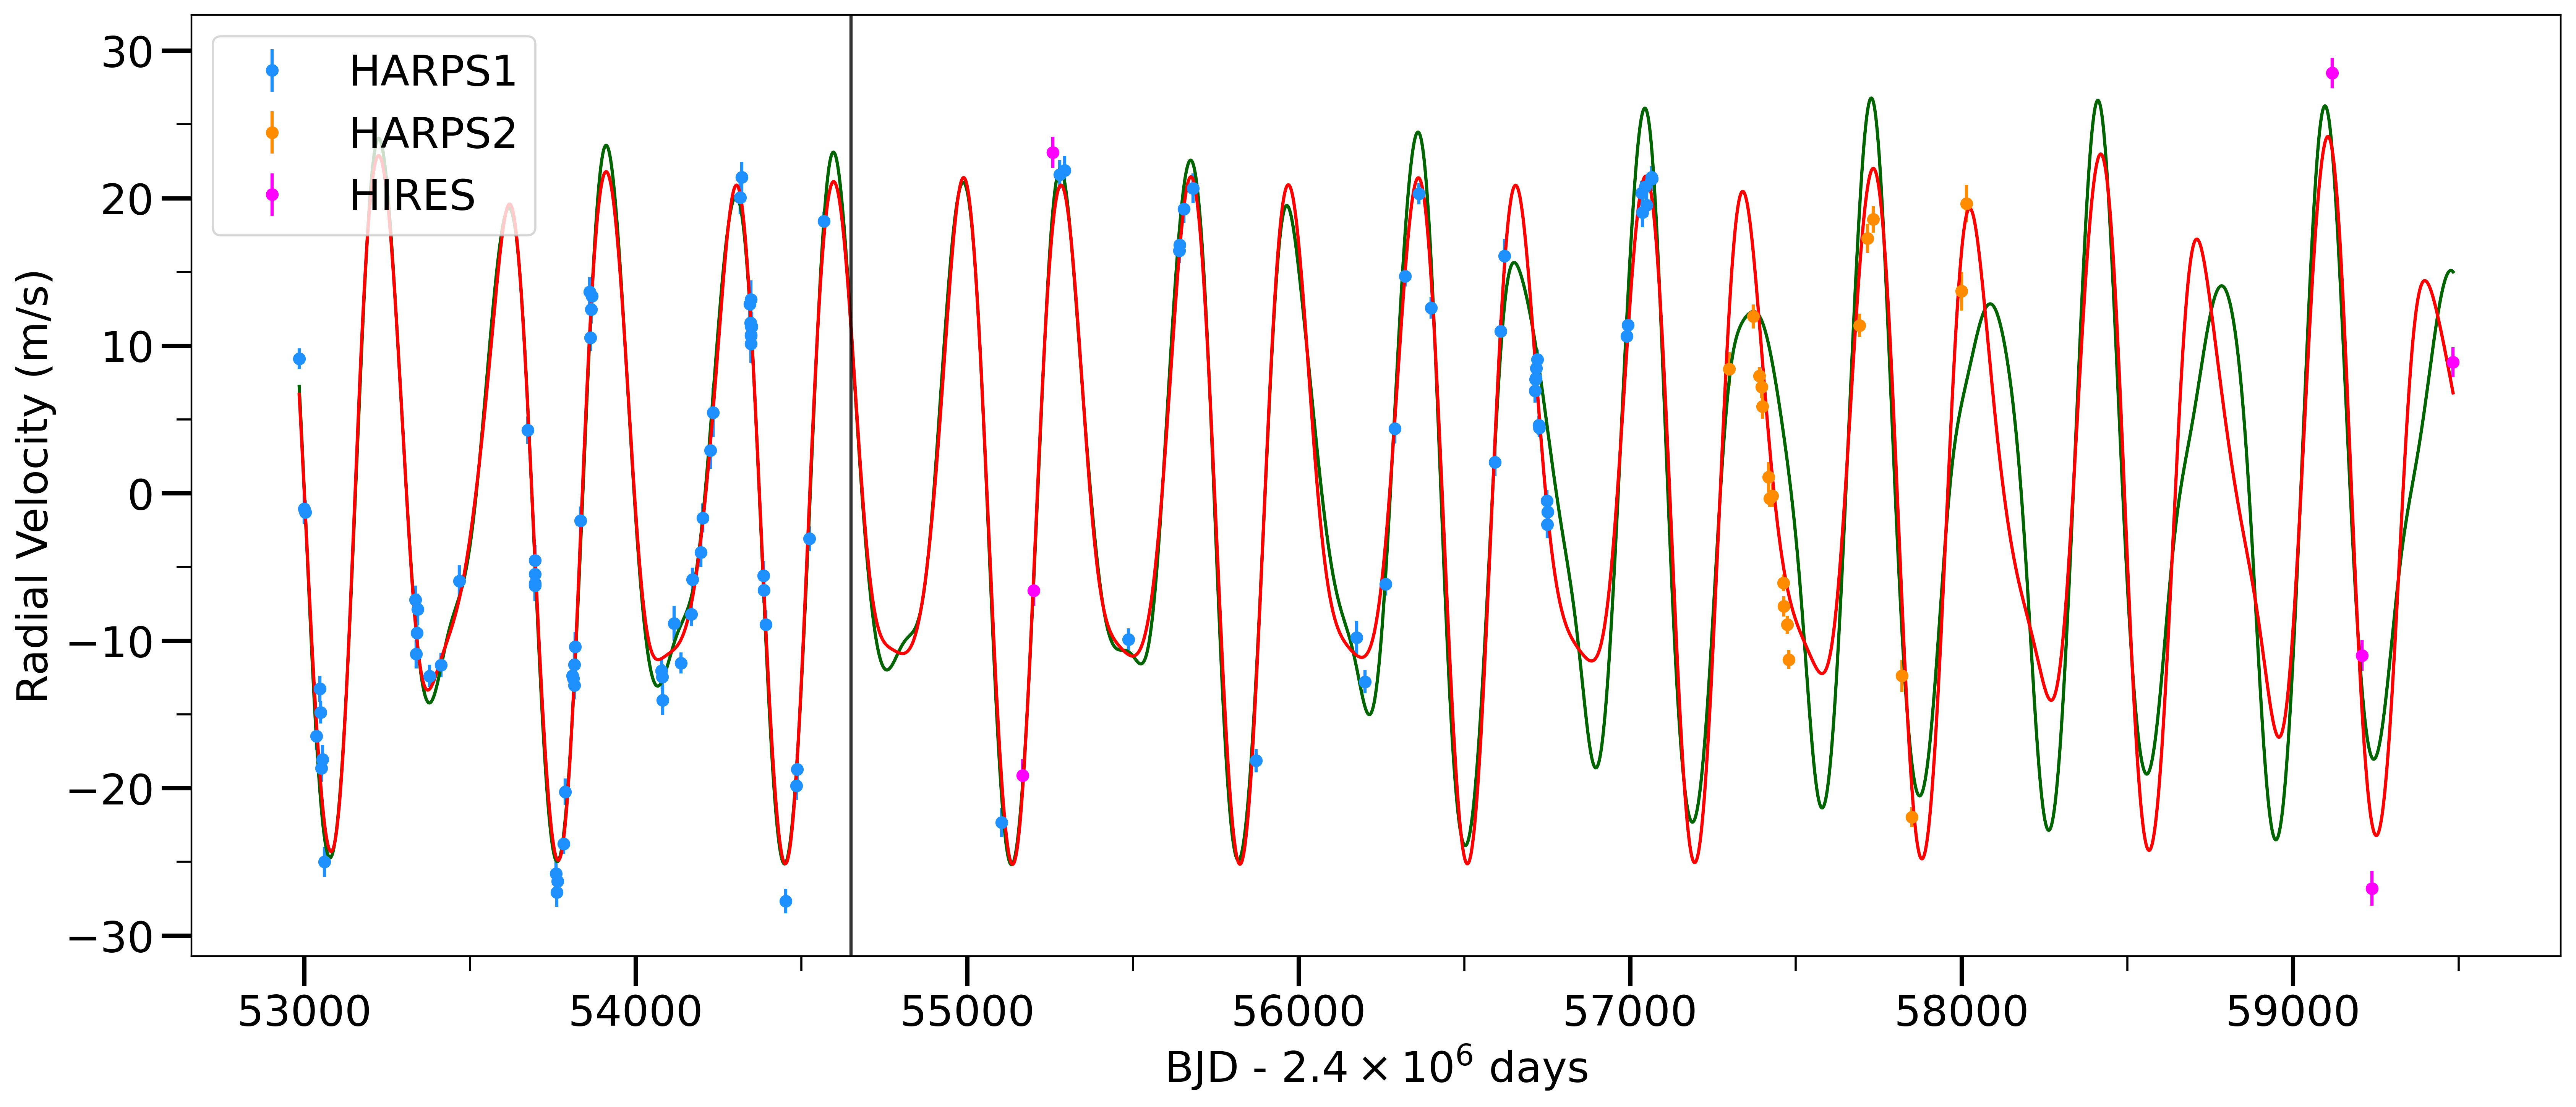

In [63]:
# create array of times to plot over (from the beginning to the end of the existing RV data:
times = np.linspace(np.min(hd_data.BJD), np.max(hd_data.BJD), int(1e5))
instruments = np.linspace(np.min(hd_data.BJD), np.max(hd_data.BJD), int(1e5))

pl.rc('font', size = 20)
fig, ax = pl.subplots(nrows=1, ncols=1, figsize=(20, 8), dpi=400)
# plot observed RVs in the hd_data df first
pl.errorbar(hd_data[hd_data.target == 'HARPS1'].BJD, hd_data[hd_data.target == 'HARPS1'].RV_mlc_nzp, 
            yerr = hd_data[hd_data.target == 'HARPS1'].e_RV_mlc_nzp, fmt = 'o', label = 'HARPS1', color='dodgerblue')
pl.errorbar(hd_data[hd_data.target == 'HARPS2'].BJD, hd_data[hd_data.target == 'HARPS2'].RV_mlc_nzp, 
            yerr = hd_data[hd_data.target == 'HARPS2'].e_RV_mlc_nzp, fmt = 'o', label = 'HARPS2', color='darkorange')
pl.errorbar(hd_data[hd_data.target == 'HIRES'].BJD, hd_data[hd_data.target == 'HIRES'].RV_mlc_nzp, 
            yerr = hd_data[hd_data.target == 'HIRES'].e_RV_mlc_nzp, fmt = 'o', label = 'HIRES', color='fuchsia')
# plot the n-body fits with sin(i) and jitter (everything without any penalty) for 
# the original parameters from H&P and the optimization using the negative log-likelihood function
pl.plot(times, get_rvs(nbody_params, instruments, times, 'ias15', time_base = obs_time_base), color='darkgreen')#, color='black')
pl.plot(times, get_rvs(best_fit_jitter.x, instruments, times, 'ias15', time_base = obs_time_base), color='red')#, color='orange')
# plot vertical line showing where the new HARPS data begins
pl.axvline(x = 54650, color='black', alpha=0.8)
pl.xlabel(r'BJD - $2.4 \times 10^6$ days'), pl.ylabel('Radial Velocity (m/s)')
# ticks
ax.set_xticks(np.linspace(53000., 59500., 14), minor=True)
ax.set_yticks(np.linspace(-30., 30., 13), minor=True)
# make ticks bigger
ax.tick_params('both', length=14, width=2., which='major')
ax.tick_params('both', length=7, width=1., which='minor')
pl.legend(loc = 'upper left')
pl.savefig('paper_figures/rv_signal_old_vs_new_final.png', pad_inches = 0)

Re-generate the eccentricity track with the new best-fit masses from the unpenalized chains (since we now take into account jitter and $\sin(i)$ as free parameters, which the original eccentricity track did not; this is for the eccentricity track overlapping the posterior $e_1 - e_2$ distribution plot:

In [64]:
def get_eccentricity_tracks_multiprocessing(params, period_ratio=3/2, t_end=3e4, tau_e_factor=3):
    """
    Gets planet eccentricity tracks for a simulation with two planets. Assumes that planets are coplanar
    and are in MMR with ratio period_ratio

    params: tuple of (masses, Ks, filename):
    masses is an array of planet masses in units of STAR MASSES (because get_simple_sim() takes masses in units of star masses)
    K is the tau_a/tau_e ratio for this eccentricity track value (e1, e2)
    filename is the filename to save the simulation archive to
    """
    masses, K, filename = params
    # K = params[1]
    # filename = params[2]

    sim = get_simple_sim(masses)

    inner = sim.particles[1]  # inner and outer planets in our simulation
    outer = sim.particles[2]

    rebx = reboundx.Extras(sim)  # eccentricity and migration forces
    # rebx.add_force(rebx.load_force('modify_orbits_forces'))
    rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

    # outer.params['tau_a'] = -10 * t_end
    inner.params['tau_e'], outer.params[
        'tau_e'] = -t_end / tau_e_factor, -t_end / tau_e_factor  # eccentricity damping, these stay constant

    tau_e = 1 / (1 / inner.params['tau_e'] + 1 / outer.params['tau_e'])

    # set the semi-major axis damping for inner and outer planets
    outer.params['tau_a'], inner.params['tau_a'] = get_tau_alphas(K * tau_e, inner.m, outer.m,
                                                                  period_ratio=period_ratio)  # 3/2 period ratio

    sim.integrate(t_end)  # integrate to t_end to find the equilibrium eccentricities
    sim.save(filename)  # save snapshot

    # get the inner and outer equilibrium eccentricities to return
    e1_track_val = inner.e
    e2_track_val = outer.e

    return e1_track_val, e2_track_val  # arrays of length Ks

Posterior median and best-fit give different results, but multiplying by median sin(i) gets pretty close I guess...

**TODO: figure out if the best-fit versus median posterior matters...**

In [65]:
np.median(m1) * np.median(sin_i), np.median(m2) * np.median(sin_i)

(0.19968745525533002, 0.5771544204549682)

In [66]:
best_m1 = semiamp_to_mass(best[1]/AUDAY_MS, STAR_MASS, best[0], best[3] ** 2 + best[4] ** 2, inclination = np.arcsin(best[-4]))
best_m2 = semiamp_to_mass(best[6]/AUDAY_MS, STAR_MASS, best[5], best[8] ** 2 + best[9] ** 2, inclination = np.arcsin(best[-4]))

best_m1, best_m2

(0.1983817288491041, 0.576193705824992)

Set up the simulations and files to save to, and then run the simulations:

In [67]:
# Set up
ecc_nsims = 1000
ecc_Ks = np.logspace(3, 0, ecc_nsims)  # K values to iterate over (try from 1000 - 1 for the big one to show an eccentricity track)

**Only run the following cell(s) if you need to re-generate simulations:**

Run $1000$ simulations for the best-fit planet masses, and for the $5\%$, $50\%$ and $95\%$ mass ratios with the same $m_1 + m_2$ as the best-fit:

In [68]:
mtot_best_fit = best_m1 + best_m2

Best-fit:

In [69]:
# ecc_sim_best = get_sim_from_params(best, 'ias15', obs_time_base)
# ecc_planet_masses_best = np.array([ecc_sim_best.particles[1].m, ecc_sim_best.particles[2].m])/STAR_MASS
# ecc_sims_best_location = 'hd_eccentricity_march_2024'  # folder to save to

# par_list_ecc_best = []
# for i, K in enumerate(ecc_Ks):
#     filename_ecc_best = f'{ecc_sims_best_location}/ecc_track_best_archive_local_{i}.bin'  # save each eccentricity point to a different file
#     par_list_ecc_best.append((ecc_planet_masses_best, K, filename_ecc_best))

# # parallelize it and run the simulations 
# pool_ecc_best = InterruptiblePool()
# ecc_track_results_best = pool_ecc_best.map(get_eccentricity_tracks_multiprocessing, par_list_ecc_best)  # get e1, e2 tracks
# # this takes ~17 minutes to run on my home machine, not too bad

# # get e1, e2 values for the eccentricity track
# e1_track_best = [tup[0] for tup in ecc_track_results_best]
# e2_track_best = [tup[1] for tup in ecc_track_results_best]

$5\%$ mass ratio:

In [70]:
# # 5th percentile planet mass ratio
# m1_5 = mtot_best_fit/(1 + np.quantile(m2/m1, 0.05))
# m2_5 = mtot_best_fit - m1_5
# ecc_planet_masses_5 = np.array([m1_5, m2_5])/STAR_MASS
# print(ecc_planet_masses_5)

# ecc_sims_5_location = 'hd_eccentricity_march_2024_5'  # folder to save to
# par_list_ecc_5 = []
# for i, K in enumerate(ecc_Ks):
#     filename_ecc_5 = f'{ecc_sims_5_location}/ecc_track_5_archive_local_{i}.bin'  # save each eccentricity point to a different file
#     par_list_ecc_5.append((ecc_planet_masses_5, K, filename_ecc_5))

# # parallelize it and run the simulations 
# pool_ecc_5 = InterruptiblePool()
# ecc_track_results_5 = pool_ecc_5.map(get_eccentricity_tracks_multiprocessing, par_list_ecc_5)  # get e1, e2 tracks
# # this takes ~17 minutes to run on my home machine, not too bad

# # get e1, e2 values for the eccentricity track
# e1_track_5 = [tup[0] for tup in ecc_track_results_5]
# e2_track_5 = [tup[1] for tup in ecc_track_results_5]

$50\%$ mass ratio:

In [71]:
# # 50th percentile planet mass ratio
# m1_50 = mtot_best_fit/(1 + np.quantile(m2/m1, 0.50))
# m2_50 = mtot_best_fit - m1_50
# ecc_planet_masses_50 = np.array([m1_50, m2_50])/STAR_MASS
# print(ecc_planet_masses_50)

# ecc_sims_50_location = 'hd_eccentricity_march_2024_50'  # folder to save to
# par_list_ecc_50 = []
# for i, K in enumerate(ecc_Ks):
#     filename_ecc_50 = f'{ecc_sims_50_location}/ecc_track_50_archive_local_{i}.bin'  # save each eccentricity point to a different file
#     par_list_ecc_50.append((ecc_planet_masses_50, K, filename_ecc_50))

# # parallelize it and run the simulations 
# pool_ecc_50 = InterruptiblePool()
# ecc_track_results_50 = pool_ecc_50.map(get_eccentricity_tracks_multiprocessing, par_list_ecc_50)  # get e1, e2 tracks
# # this takes ~17 minutes to run on my home machine, not too bad

# # get e1, e2 values for the eccentricity track
# e1_track_50 = [tup[0] for tup in ecc_track_results_50]
# e2_track_50 = [tup[1] for tup in ecc_track_results_50]

$95\%$ mass ratio:

In [72]:
# # 95th percentile planet mass ratio
# m1_95 = mtot_best_fit/(1 + np.quantile(m2/m1, 0.95))
# m2_95 = mtot_best_fit - m1_95
# ecc_planet_masses_95 = np.array([m1_95, m2_95])/STAR_MASS
# print(ecc_planet_masses_95)

# ecc_sims_95_location = 'hd_eccentricity_march_2024_95'  # folder to save to
# par_list_ecc_95 = []
# for i, K in enumerate(ecc_Ks):
#     filename_ecc_95 = f'{ecc_sims_95_location}/ecc_track_95_archive_local_{i}.bin'  # save each eccentricity point to a different file
#     par_list_ecc_95.append((ecc_planet_masses_95, K, filename_ecc_95))

# # parallelize it and run the simulations 
# pool_ecc_95 = InterruptiblePool()
# ecc_track_results_95 = pool_ecc_95.map(get_eccentricity_tracks_multiprocessing, par_list_ecc_95)  # get e1, e2 tracks
# # this takes ~17 minutes to run on my home machine, not too bad

# # get e1, e2 values for the eccentricity track
# e1_track_95 = [tup[0] for tup in ecc_track_results_95]
# e2_track_95 = [tup[1] for tup in ecc_track_results_95]

**Run the following cells to get the eccentricity track from the saved simulations:**

In [73]:
ecc_sims_best_location = 'hd_eccentricity_march_2024'  # folder to save to
ecc_sims_5_location = 'hd_eccentricity_march_2024_5'  # folder to save to
ecc_sims_50_location = 'hd_eccentricity_march_2024_50'  # folder to save to
ecc_sims_95_location = 'hd_eccentricity_march_2024_95'  # folder to save to

e1_track_best, e2_track_best = np.zeros(len(ecc_Ks)), np.zeros(len(ecc_Ks))
e1_track_5, e2_track_5 = np.zeros(len(ecc_Ks)), np.zeros(len(ecc_Ks))
e1_track_50, e2_track_50 = np.zeros(len(ecc_Ks)), np.zeros(len(ecc_Ks))
e1_track_95, e2_track_95 = np.zeros(len(ecc_Ks)), np.zeros(len(ecc_Ks))

for i in range(0, len(ecc_Ks)):
    # get the simulations for best, 5%, 50%, 95%
    ecc_sim_best = rb.Simulation(f'{ecc_sims_best_location}/ecc_track_best_archive_local_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    ecc_sim_5 = rb.Simulation(f'{ecc_sims_5_location}/ecc_track_5_archive_local_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    ecc_sim_50 = rb.Simulation(f'{ecc_sims_50_location}/ecc_track_50_archive_local_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder
    ecc_sim_95 = rb.Simulation(f'{ecc_sims_95_location}/ecc_track_95_archive_local_{i}.bin')  # get the ith eccentricity simulation from the ecc sims folder

    # get the inner, outer planets for best, 5, 50, 95
    inner_best = ecc_sim_best.particles[1]
    outer_best = ecc_sim_best.particles[2]
    inner_5 = ecc_sim_5.particles[1]
    outer_5 = ecc_sim_5.particles[2]
    inner_50 = ecc_sim_50.particles[1]
    outer_50 = ecc_sim_50.particles[2]
    inner_95 = ecc_sim_95.particles[1]
    outer_95 = ecc_sim_95.particles[2]

    # get the e1, e2 values for all the simulations
    e1_track_best[i] = inner_best.e  # add the e1/e2 values for that simulation
    e2_track_best[i] = outer_best.e
    e1_track_5[i] = inner_5.e  # add the e1/e2 values for that simulation
    e2_track_5[i] = outer_5.e
    e1_track_50[i] = inner_50.e  # add the e1/e2 values for that simulation
    e2_track_50[i] = outer_50.e
    e1_track_95[i] = inner_95.e  # add the e1/e2 values for that simulation
    e2_track_95[i] = outer_95.e

#### Figure in paper; new eccentricity track for unpenalized chains

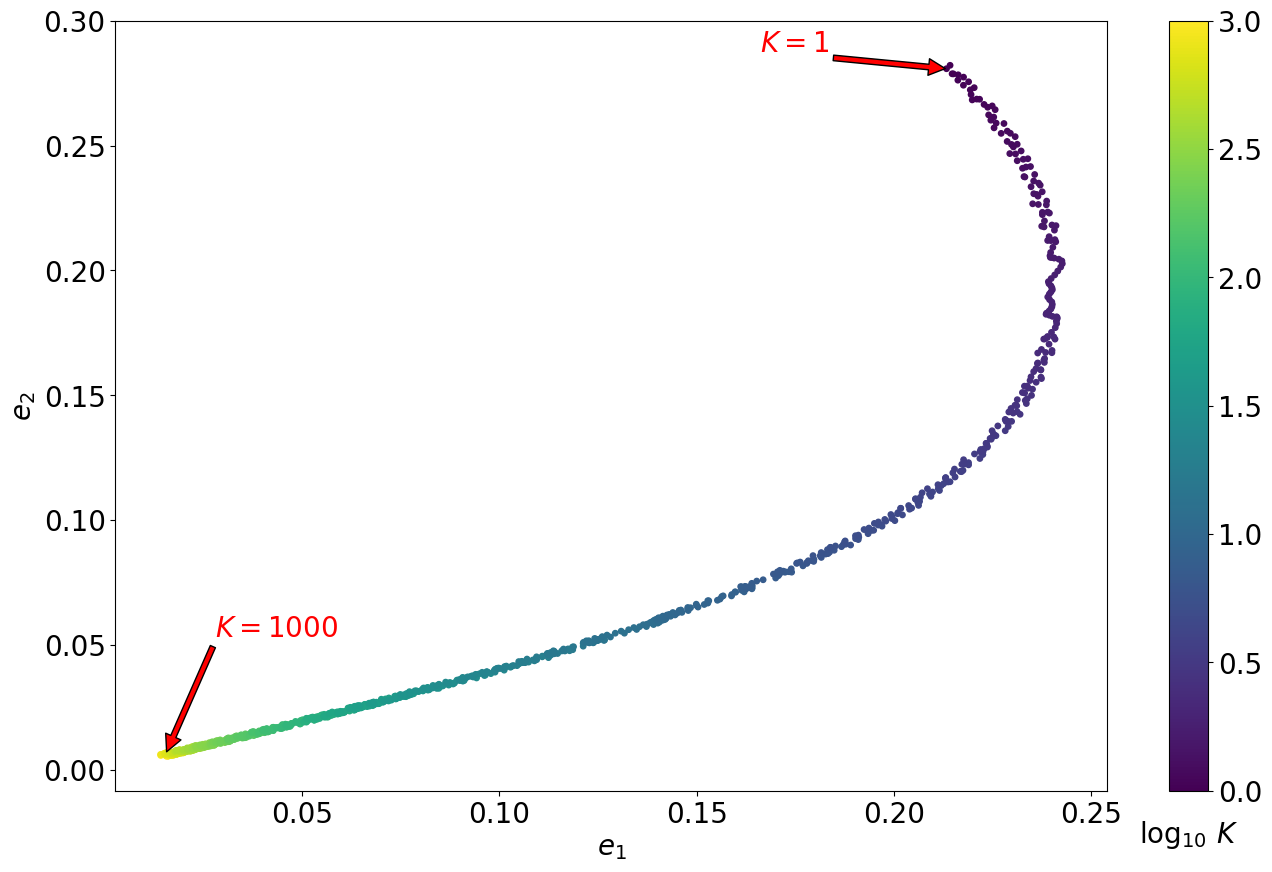

In [74]:
pl.rc('font', size=20)
fig = pl.figure(figsize = (16, 10))
ax = fig.add_subplot(111)
# default is s=25
# 1000 annotation
ax.annotate(fr'$K = 1000$', xy=(e1_track_best[np.where(ecc_Ks == 1000)[0][0]], e2_track_best[np.where(ecc_Ks == 1000)[0][0]]), 
                               xycoords='data', textcoords='axes fraction', xytext=(0.1, 0.2), 
            arrowprops=dict(facecolor='red', shrink=0.01), color ='red')
# 1 annotation
ax.annotate(fr'$K = 1$', xy=(e1_track_best[np.where(ecc_Ks == 1)[0][0]], e2_track_best[np.where(ecc_Ks == 1)[0][0]]), 
                               xycoords='data', textcoords='axes fraction', xytext=(0.65, 0.96), 
            arrowprops=dict(facecolor='red', shrink=0.01), color ='red')
pl.scatter(e1_track_best, e2_track_best, s=15, c=np.log10(ecc_Ks), cmap='viridis')
pl.xlabel(r'$e_1$'), pl.ylabel(r'$e_2$')
pl.ylim(top=0.3)
# colourbar
cbar = pl.colorbar()
cbar.ax.get_xaxis().labelpad=20
cbar.ax.set_xlabel(r'$\log_{10}\,K$', rotation=0)
# save
pl.savefig('paper_figures/ecc_track_final.png')

Now plot the eccentricity track on top of the unpenalized $e_1-e_2$ posteriors:

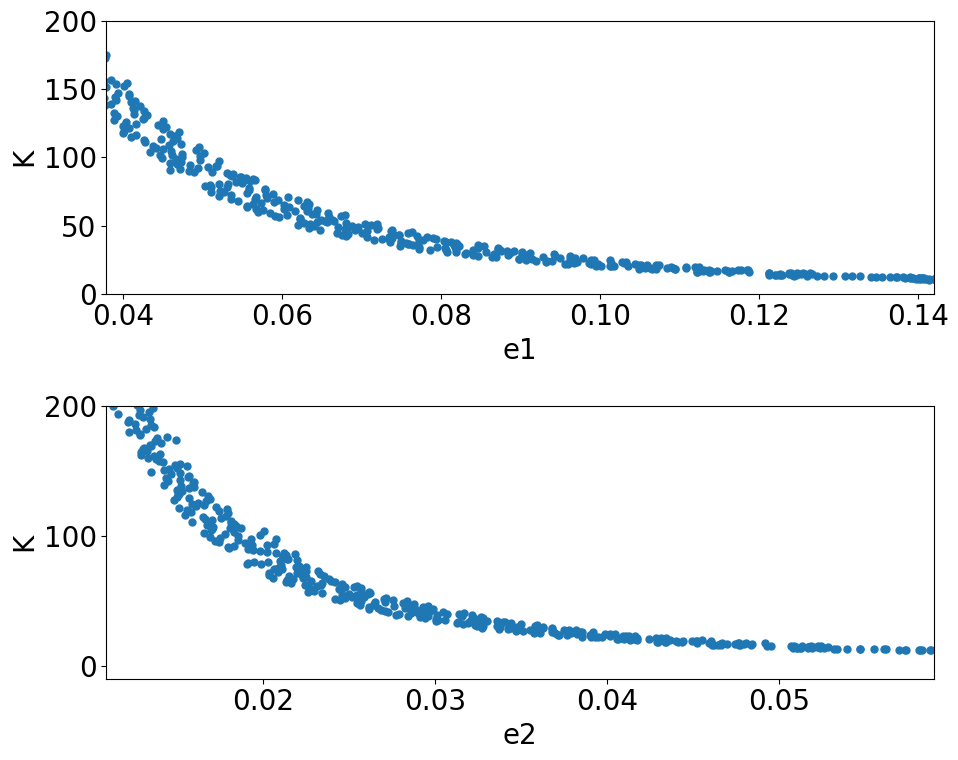

In [75]:
# these bounds are for 99% contours
bounds_e1_best = (0.0379, 0.142)
bounds_e2_best = (0.0109, 0.059)  # eyeball these looking at the graph below

# these bounds are for 95% contours
# bounds_e1_best = (0.042, 0.134)
# bounds_e2_best = (0.016, 0.056)  # eyeball these looking at the graph below

fig, axs = pl.subplots(2, 1, figsize = (10, 8))
f1 = axs[0]
f2 = axs[1]
# e1 vs K
f1.scatter(e1_track_best, ecc_Ks)
# 14 points within the x and ylims (just eyeball what looks close to the distribution)
# eyeball it, make it easier to see
f1.set(xlim = bounds_e1_best, ylim = (0, 200), xlabel='e1', ylabel='K')
# e2 vs K
f2.scatter(e2_track_best, ecc_Ks)
# eyeball it again to get the same 13 points
f2.set(xlim = bounds_e2_best, ylim = (-10, 200), xlabel = 'e2', ylabel='K')
pl.tight_layout()
pl.show()

In [76]:
# points that fall within the e1, e2 joint distribution produced by the mcmc
fit_indices_best = (bounds_e1_best[0] < np.array(e1_track_best)) & (np.array(e1_track_best) < 
                                                                    bounds_e1_best[1]) & (bounds_e2_best[0] < 
                                                                                     np.array(e2_track_best)) & (np.array(e2_track_best) < 
                                                                                                            bounds_e2_best[1])

ecc_K_dist_bounds_best = ecc_Ks[np.where(fit_indices_best)]
e1_dist_best = np.array(e1_track_best)[np.where(fit_indices_best)]
e2_dist_best = np.array(e2_track_best)[np.where(fit_indices_best)]

Compare $5$th, $50$th, $95$th percentile ecc tracks -- barely makes a difference:

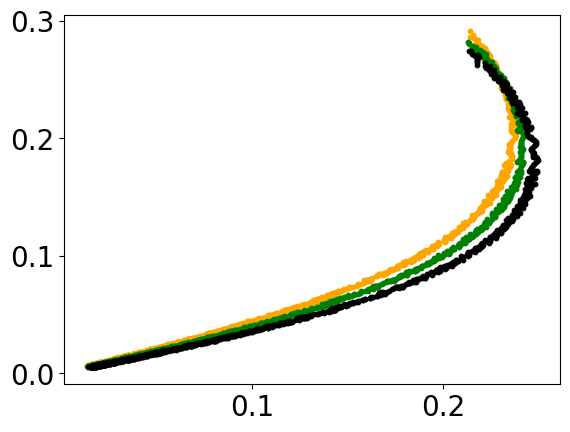

In [77]:
pl.scatter(e1_track_5, e2_track_5, s=10, c='orange')
pl.scatter(e1_track_50, e2_track_50, s=10, c='g')
pl.scatter(e1_track_95, e2_track_95, s=10, c='k')

#### Figure in paper; new eccentricity track overlaid with $e_1-e_2$ posteriors for $A = 0.1$ penalty chains

In [78]:
# get the strong penalty MC samples (A = 0.1)
strong_penalty_mc_samples = MCSamples(samples=np.transpose(np.array(get_penalized_es(1))), names = [r'e_1', r'e_2'], labels = [r'e_1', r'e_2'])
strong_penalty_mc_samples.updateSettings({'contours': [0.68, 0.95, 0.99]})

Removed no burn in


In [79]:
np.quantile(m2/m1, [0.05, 0.5, 0.95])

array([2.6565365 , 2.89239093, 3.16458084])

In [80]:
# ecc_planet_masses_5[1]/ecc_planet_masses_5[0], ecc_planet_masses_50[1]/ecc_planet_masses_50[0], ecc_planet_masses_95[1]/ecc_planet_masses_95[0]

<Figure size 2560x1920 with 0 Axes>

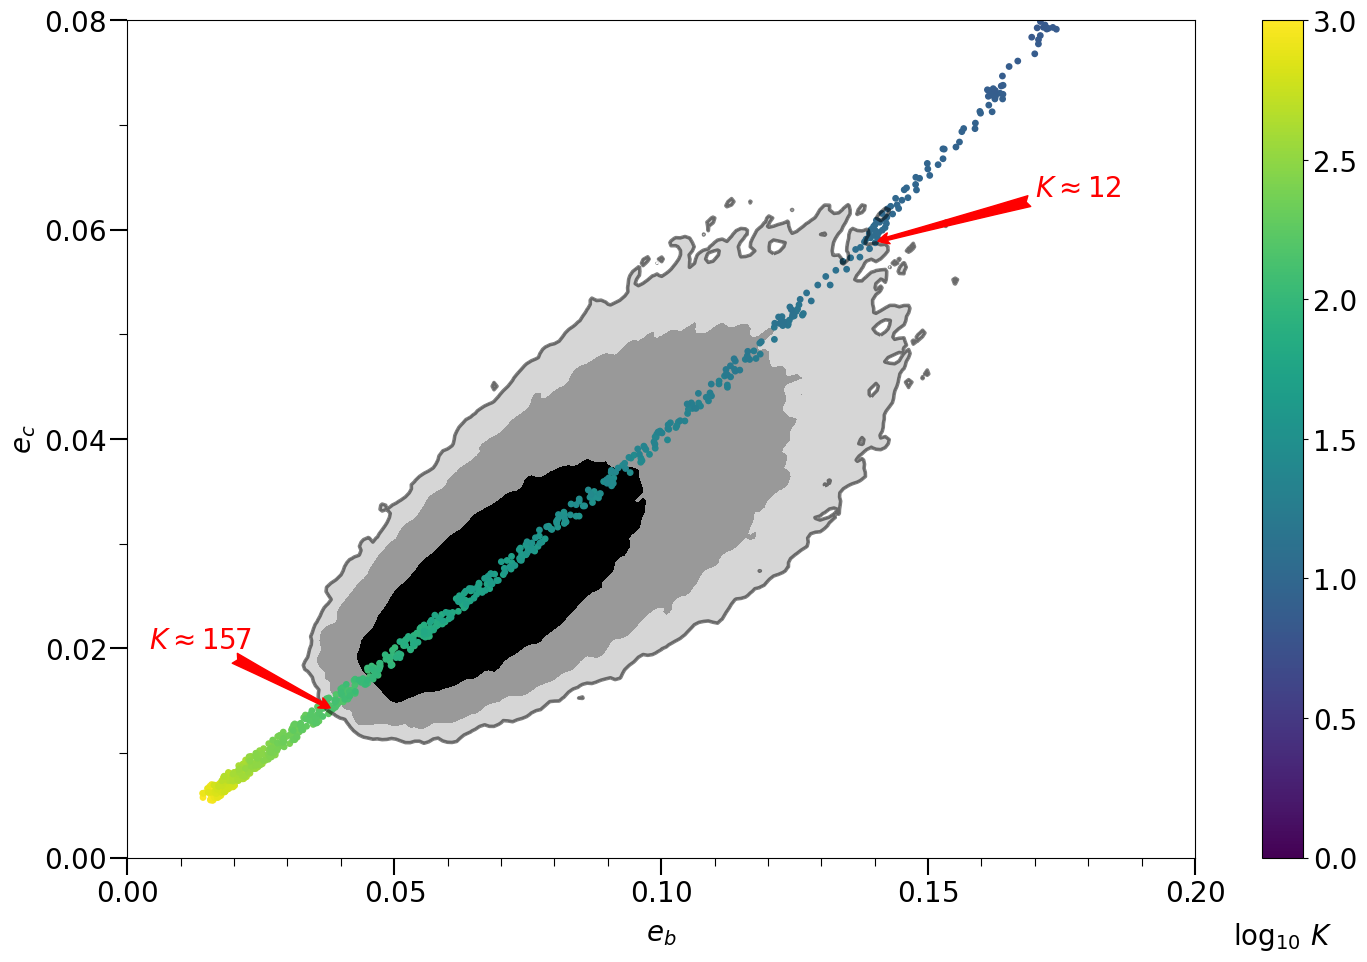

In [81]:
# plot
# e1-e2 posteriors
pl.figure(dpi=400)
g3 = plots.get_single_plotter(width_inch = 15, ratio=0.65, rc_sizes=20)
g3.settings.num_plot_contours = 3
g3.settings.solid_colors = ['black']
g3.plot_2d(strong_penalty_mc_samples, r'e_1', r'e_2', shaded=True, filled=True)
# g3.set_axes().set_xlim(right=0.25)
# g3.set_axes().set_ylim(top=0.3)
# set minor xticks, yticks
g3.set_axes().set_xticks(np.linspace(0., 0.2, 21), minor=True)
g3.set_axes().set_yticks(np.linspace(0., 0.08, 9), minor=True)
# best-fit eccentricity
# pl.scatter(e1_best, e2_best, s=40, c = 'orange', label = 'Best fit')  # best fit eccentricity
# eccentricity tracks
pl.scatter(e1_track_best, e2_track_best, s=15, c=np.log10(ecc_Ks), cmap='viridis')
# pl.scatter(e1_track_5, e2_track_5, s=10, c='orange')
# pl.scatter(e1_track_50, e2_track_50, s=10, c='g')
# pl.scatter(e1_track_95, e2_track_95, s=10, c='k')
# make ticks bigger
g3.set_axes().tick_params('both', length=12, width=1.5, which='major')
g3.set_axes().tick_params('both', length=6, width=0.8, which='minor')
# colorbar
cbar = pl.colorbar()
cbar.ax.get_xaxis().labelpad = 45
cbar.ax.set_xlabel(r'$\log_{10}\,K$', rotation=0)
# plot the bounds of the eccentricity track
# pl.scatter(e1_dist_best, e2_dist_best, c='r')
# pl.scatter(e1_dist_best, e2_dist_best, c=np.log10(ecc_Ks), cmap='viridis_r')
# annotate for the two points at the end of the region of interest:
roundto = 0  # number of digits to round annotations to
pl.annotate(fr'$K \approx {int(np.round(ecc_K_dist_bounds_best[-1], roundto))}$', xy=(np.max(e1_dist_best), np.max(e2_dist_best)), xycoords='data', 
            textcoords='axes fraction', xytext=(0.85, 0.79), arrowprops=dict(arrowstyle='fancy', color='red'), color ='red')
pl.annotate(fr'$K \approx {int(np.round(ecc_K_dist_bounds_best[0], roundto))}$', xy=(np.min(e1_dist_best), np.min(e2_dist_best)), xycoords='data', 
            textcoords='axes fraction', xytext=(0.02, 0.25), arrowprops=dict(arrowstyle='fancy', color='red'), color ='red')
# labels
pl.xlabel(r'$e_{b}$'), pl.ylabel(r'$e_{c}$')
# legend
# pl.legend()
# save figure
pl.tight_layout()
pl.savefig('paper_figures/ecc_track_with_posteriors.png')

## testing:

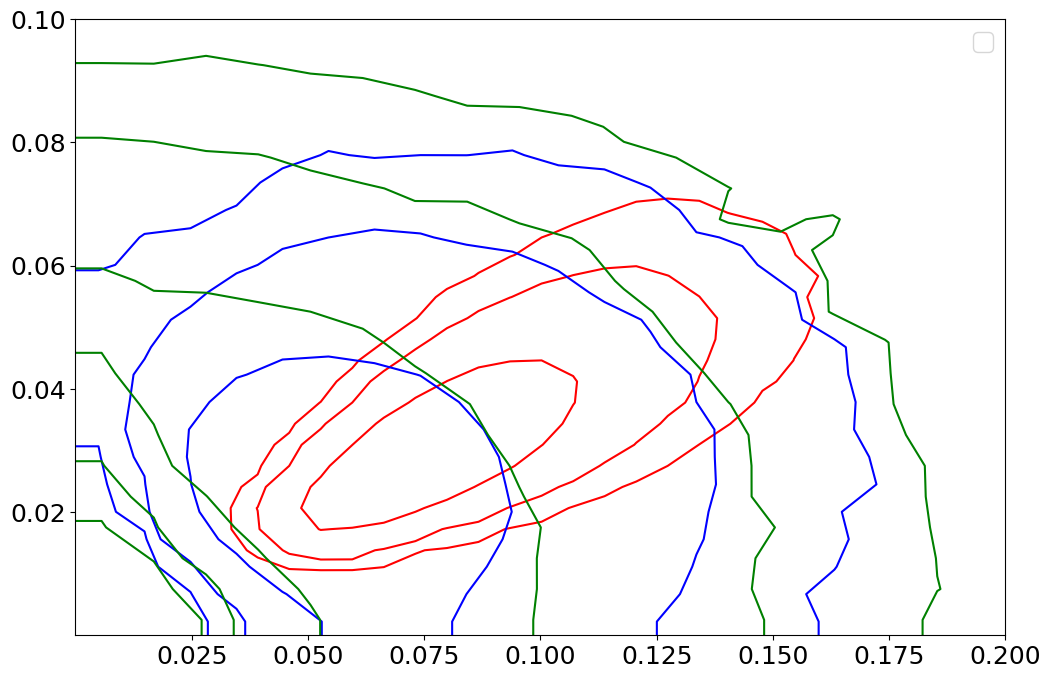

In [52]:
# plot contours for A_lib = [0.1, 0.5, 0.8] (weak, intermediate, strong constraints) 
penalties = [1, 5, 0]
colours = ['r', 'b', 'g']

pl.figure(figsize = (12, 8))
for i, penalty in enumerate(penalties):
    # get the data, making sure to drop the burn-in phase
    penalized_samples = np.array(h5py.File(f'../mcmc_hd45364_everything_with_libration_penalty_variable_{penalty}.h5', 'r')['mcmc']['chain'])[burnin:]  # import data
    # truncating samples and log_prob if they're not exactly 50000 steps
    penalized_samples = penalized_samples[~np.all(penalized_samples == 0, axis=2)]
    penalized_samples = penalized_samples.reshape(int(penalized_samples.shape[0]/50), 50, penalized_samples.shape[-1])
    # compute e1 and e2
    penalized_e1s = penalized_samples[:, :, 3] ** 2 + penalized_samples[:, :, 4] ** 2  # computing eccentricity
    penalized_e2s = penalized_samples[:, :, 8] ** 2 + penalized_samples[:, :, 9] ** 2
    # cornerplot the posteriors for e1, e2
    # default is 20 bins, gives a pretty smooth plot
    corner.hist2d(penalized_e1s.reshape(-1), penalized_e2s.reshape(-1), s=0.1, bins=30, plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color=colours[i], label=f'Alib = 0.{penalty}')
pl.xlim(right=0.2)  # seems to cut off a little past here
pl.ylim(top=0.1)  # and cut off a little past here too
pl.legend()
pl.show()

In [44]:
test_sim = get_sim_from_params(fit_params, integrator='ias15', time_base=obs_time_base)
test_sim.particles[1].m/STAR_MASS, test_sim.particles[2].m/STAR_MASS

(0.00021814016556630797, 0.0006133338873173085)

In [45]:
masses_test

NameError: name 'masses_test' is not defined

In [ ]:
masses_test = [m1_init, m1_init * m2m1_median]
K_test = 100
filename_test = f'test_archive_local_{K_test}.bin'

params_test = ([test_sim.particles[1].m/STAR_MASS, test_sim.particles[2].m/STAR_MASS], K_test, filename_test)

get_maximum_stable_masses(params_test)

In [ ]:
pl.hist(m1sini.reshape(-1))
pl.hist(m2sini.reshape(-1))

- Mass upper limit as function of tau_a/tau_e (e.g., geomspace(3,1000)):
    - Start sims with small masses (e.g., m~1e-6), taking m1/m2 based on posterior median
    - Migrate and capture in resonance for fixed tau_a/tau_e
    - turn off tau_a and tau_e
    - Use reboundx grow masses and determine maximum stable masses